In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
import scipy as sp
import json
import scipy
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
from scipy.special import erf

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.clifford_averager_program
imported experiments.qubit_cavity.photo_resolved_pulse_probe
imported experiments.qubit_cavity.small_chi_calibration
imported experiments.qubit_cavity.displace_ramsey
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.single_mode_wigner_tomography
imported experiments.qubit_cavity.test_opt
imported experiments.qubit_cavity.test_opt2
imported experiments.qubit_cavity.non_demolution_readout
imported experiments.qubit_cavity.qubit_cavity_opt
imported experiments.qubit_cavity.test_opt_ecd
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.single_mode_wigner_tomography - Copy
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.twoQ_state_tomography
imported experiment

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path='H:\\Shared drives\\multimode\\Multimode\\experiment\\240403\\data'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\multimode\Multimode\experiment\240403\data


In [5]:
config_file = 'H:\\Shared drives\\multimode\\Multimode\\experiment\\240403\\config_rfsoc_ziqian.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = config_file
print('Config will be', config_path)

Config will be H:\Shared drives\multimode\Multimode\experiment\240403\config_rfsoc_ziqian.yml


# Qubit/resonator to probe

In [6]:
qubit_i = 0

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab

In [9]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x1fc8ec6f130; not connected; for PYRO:obj_99d7610b775a42b293793b8c6b0930a1@192.168.137.101:45533>


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Thu Feb 17 16:46:52 2022

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC ti

In [11]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

expt_path='H:\\Shared drives\\multimode\\Multimode\\experiment\\240403\\data'
print('Data are extracted from', expt_path)

Data are extracted from H:\Shared drives\multimode\Multimode\experiment\240403\data


# Cavity spectroscopy

## Manipulate 1

### Displace cavity first then measure

In [30]:
qubit_i = 0

qspec = meas.PulseProbePhotonResolvedExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 4
npts = 200
cavity_i = 0  # manipulate 1=0, maniupulate 2=1
qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Qubit probe constant pulse length [us]
    gain=20, # Qubit pulse gain
    pulse_type='gaussian',
    wait_qubit = False,
    qubit=qubit_i,
    cavity_drive = True,
    cavity_name = cavity_i,
    cavity_gain = 15,  
    cavity_length = 2   # constant pulses of cavity [us]
)
qspec.cfg.device.readout.relax_delay = 200 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency = 748.0
# # qspec.cfg.device.readout.phase = 50
# qspec.cfg.device.readout.gain = 3000

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3577.588227381174], 'f_ge_resolved': [3577.588227381174], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [23652], 'sigma': [0.03], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [52], 'sigma': [0.1], 'length': 10, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [11444], 'sigma': [0.03], 'type': 'gauss'}, 'pi_ef': {'gain': [11733], 'sigma': [0.04], 'type': 'gauss'}, 'hpi_ef': {'gain': [5087], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.34527994145901175, -0.1978836161192703], [-0.34527994145901175, -0.006572659352514165, 0.0], [-0.1978836161192703, 0.0, -0.00341724

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3576.24925567538, HWHM 0.24074392762254693
Found peak in I at [MHz] 3576.2627761205335, HWHM 0.21999406552871634
Found peak in Q at [MHz] 3577.979887167819, HWHM 0.00036770345677119464


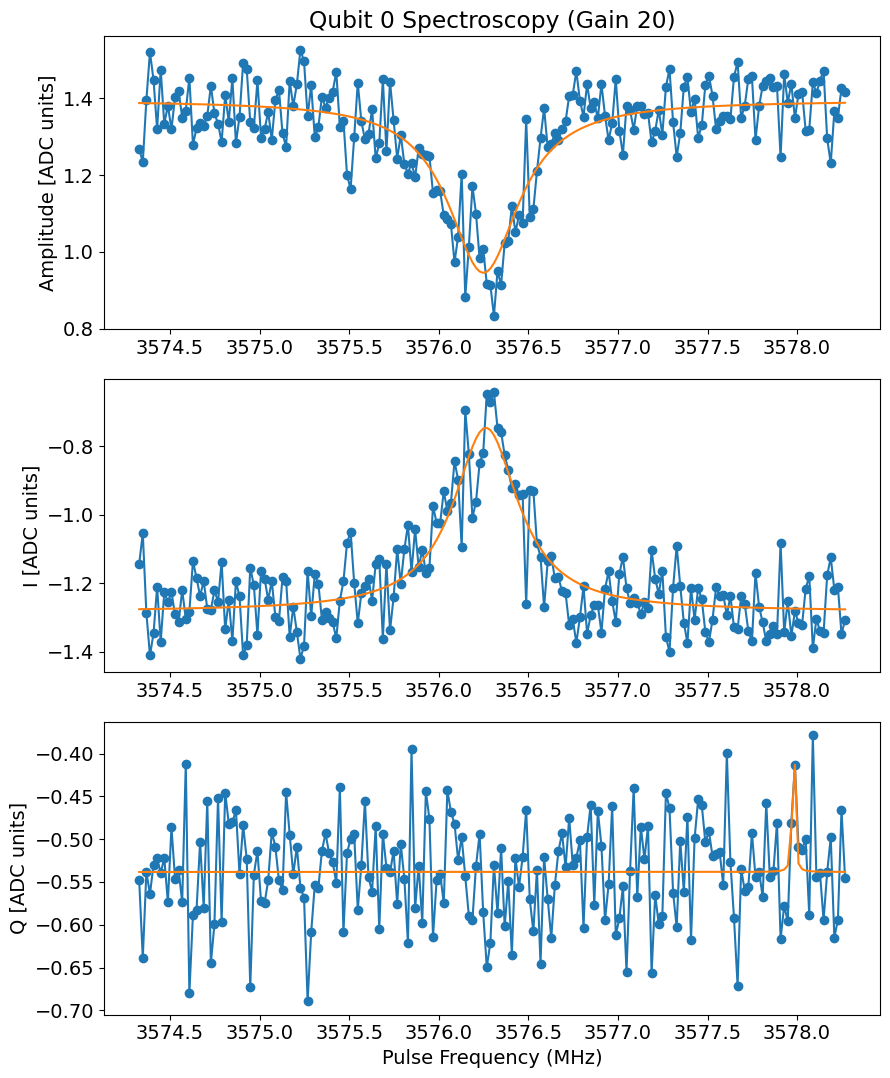

In [37]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [150]:
qspec.save_data()

Saving H:\My Drive\My project\Multimode\experiment\230914\data\00002_CavitySpectroscopy.h5


In [18]:
1/(soc.cycles2us(50))

8.6016

In [24]:
1/(soc.cycles2us(25)*200)

0.086016

# Wigner tomography

## Measurement non-demolution test, sweep waiting time between readout

In [31]:
chi_calibration = meas.DemolutionMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"demolution_calibration",
    config_file=config_path,
)

chi_calibration.cfg.expt = dict(
    cavity_name = 0,   # displaced cavity name
    time_start = 0.0,
    time_step = 0.5,
    time_expts = 8,
    reps=10000,
    # rounds=10,
    qubits=[0],
    pi_pulse = False,   # Whether to flip qubit ge between two sequential readout
    )


print(chi_calibration.cfg)

import Pyro4.util
try:
    chi_calibration.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [3568.3], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.3], 'f_ge_resolved': [3568.3], 'f_ge_idle': [3567.920628692002], 'f_ef': [3425.189077647194], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [9846], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [9846], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [50], 'sigma': [0.1], 'length': 6.297028591294849, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [4923], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [5978], 'sigma': [0.045], 'type': 'gauss'}, 'hpi_ef': {'gain': [3099], 'sigma': [0.045], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'si

  0%|          | 0/8 [00:00<?, ?it/s]

### no pi pulse flip between two readouts

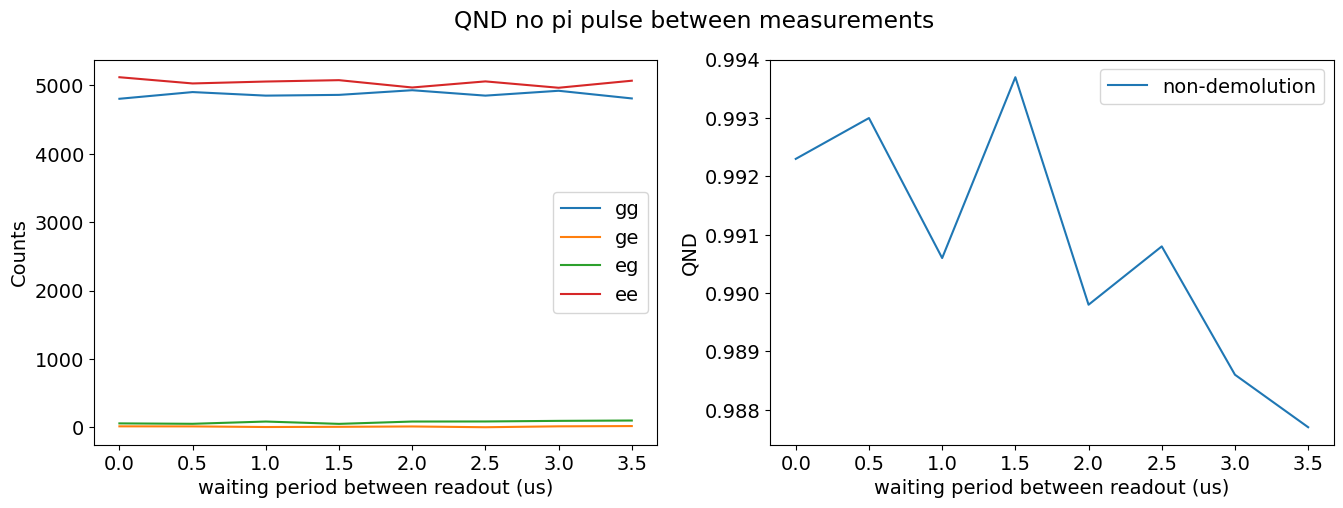

In [32]:
readout_list = chi_calibration.cfg.expt["time_start"] + chi_calibration.cfg.expt["time_step"] * np.arange(chi_calibration.cfg.expt["time_expts"])
gg_list = []
ge_list = []
eg_list = []
ee_list = []
non_demolution = []
for i in range(len(readout_list)):
    gg = 0
    ge = 0
    eg = 0
    ee = 0
    for j in range(len(chi_calibration.data['i0'][0][0])):
        #  check if the counts are the same as initial counts
        if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ee += 1
            else:
                eg +=1
        else:  # classified as g
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ge +=1
            else:
                gg += 1
    gg_list.append(gg)
    ge_list.append(ge)
    eg_list.append(eg)
    ee_list.append(ee)
    non_demolution.append((gg+ee)/(gg+ge+eg+ee))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('QND no pi pulse between measurements')
axs[0].plot(readout_list, gg_list, label='gg')
axs[0].plot(readout_list, ge_list, label='ge')
axs[0].plot(readout_list, eg_list, label='eg')
axs[0].plot(readout_list, ee_list, label='ee')
axs[0].set_xlabel('waiting period between readout (us)')
axs[0].set_ylabel('Counts')
axs[0].legend()

axs[1].plot(readout_list, non_demolution, label='non-demolution')
axs[1].set_xlabel('waiting period between readout (us)')
axs[1].set_ylabel('QND')
axs[1].legend()

### pi pulse flip between two readouts

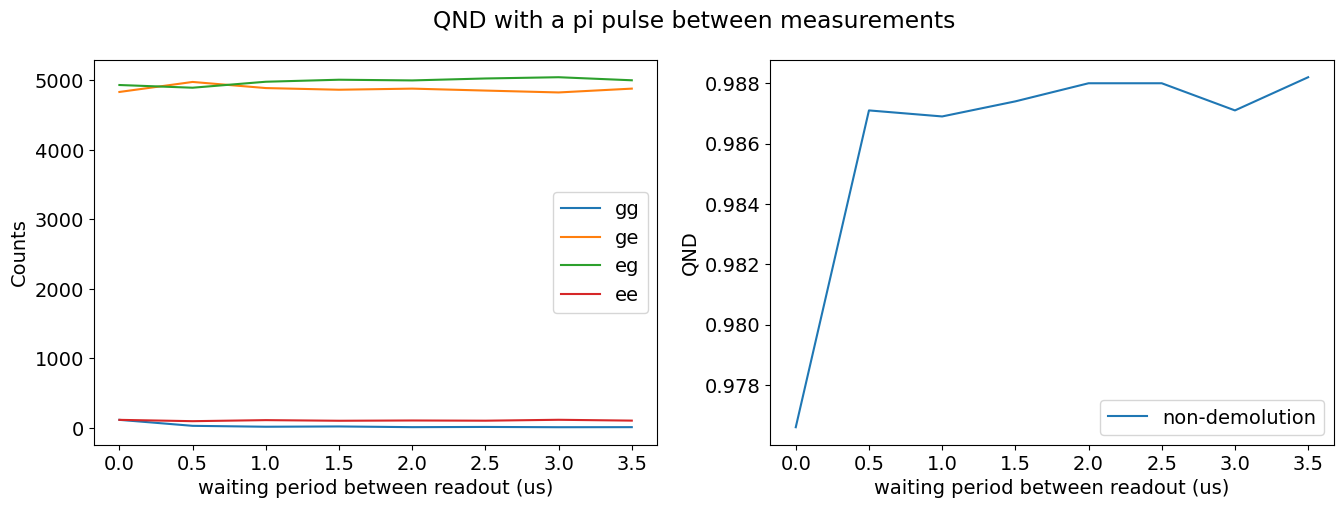

In [30]:
readout_list = chi_calibration.cfg.expt["time_start"] + chi_calibration.cfg.expt["time_step"] * np.arange(chi_calibration.cfg.expt["time_expts"])
gg_list = []
ge_list = []
eg_list = []
ee_list = []
non_demolution = []
for i in range(len(readout_list)):
    gg = 0
    ge = 0
    eg = 0
    ee = 0
    for j in range(len(chi_calibration.data['i0'][0][0])):
        #  check if the counts are the same as initial counts
        if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ee += 1
            else:
                eg +=1
        else:  # classified as g
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ge +=1
            else:
                gg += 1
    gg_list.append(gg)
    ge_list.append(ge)
    eg_list.append(eg)
    ee_list.append(ee)
    non_demolution.append((ge+eg)/(gg+ge+eg+ee))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('QND with a pi pulse between measurements')
axs[0].plot(readout_list, gg_list, label='gg')
axs[0].plot(readout_list, ge_list, label='ge')
axs[0].plot(readout_list, eg_list, label='eg')
axs[0].plot(readout_list, ee_list, label='ee')
axs[0].set_xlabel('waiting period between readout (us)')
axs[0].set_ylabel('Counts')
axs[0].legend()

axs[1].plot(readout_list, non_demolution, label='non-demolution')
axs[1].set_xlabel('waiting period between readout (us)')
axs[1].set_ylabel('QND')
axs[1].legend()

### narrow BW pi pulse between two readout

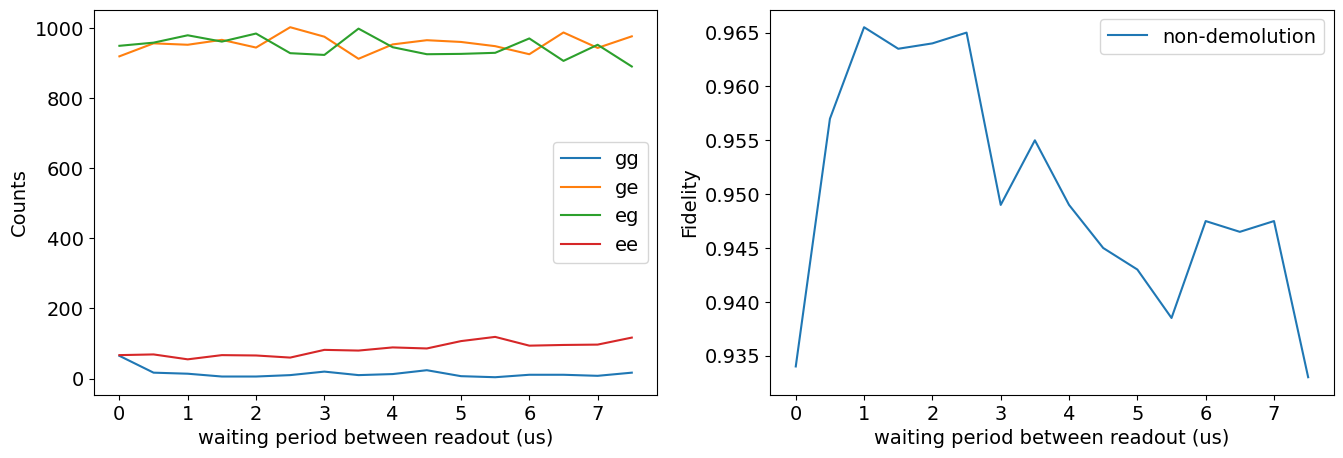

In [74]:
readout_list = chi_calibration.cfg.expt["time_start"] + chi_calibration.cfg.expt["time_step"] * np.arange(chi_calibration.cfg.expt["time_expts"])
gg_list = []
ge_list = []
eg_list = []
ee_list = []
non_demolution = []
for i in range(len(readout_list)):
    gg = 0
    ge = 0
    eg = 0
    ee = 0
    for j in range(len(chi_calibration.data['i0'][0][0])):
        #  check if the counts are the same as initial counts
        if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ee += 1
            else:
                eg +=1
        else:  # classified as g
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ge +=1
            else:
                gg += 1
    gg_list.append(gg)
    ge_list.append(ge)
    eg_list.append(eg)
    ee_list.append(ee)
    non_demolution.append((ge+eg)/(gg+ge+eg+ee))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axs[0].plot(readout_list, gg_list, label='gg')
axs[0].plot(readout_list, ge_list, label='ge')
axs[0].plot(readout_list, eg_list, label='eg')
axs[0].plot(readout_list, ee_list, label='ee')
axs[0].set_xlabel('waiting period between readout (us)')
axs[0].set_ylabel('Counts')
axs[0].legend()

axs[1].plot(readout_list, non_demolution, label='non-demolution')
axs[1].set_xlabel('waiting period between readout (us)')
axs[1].set_ylabel('Fidelity')
axs[1].legend()

## Cavity dispersive shift and self Kerr calibration

In [112]:
soc.cycles2us(41)

0.09533110119047619

### sweep waiting time between readout

In [82]:
chi_calibration = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"small_chi__calibration",
    config_file=config_path,
)

wait_list = np.linspace(0.0, 8.0, 16)

first = []
second = []

for tt in wait_list:

    chi_calibration.cfg.expt = dict(
        cavity_name = 0,   # displaced cavity name
        phase_start=-50,   # cavity displacement phase sweep in deg
        phase_step=2,
        phase_expts=51,
        displace_sigma = 0.05,  # cavity displace length in us
        displace_gain = 0,
        tp = 0.1,  # waiting time us
        # expts=1,  # not used but required for Raverage program
        # start=0,  # not used but required for Raverage program
        # step=1,   # not used but required for Raverage program
        reps=1000,
        # rounds=10,
        qubits=[0],
        pulse_ge = True,   # Whether to pulse qubit to |e> for the calibration
        displace_number = 1,  # How many repeat time of cavity displacement
        wait_time_r = tt   # wait time between readout in us
        )


    print(chi_calibration.cfg)

    import Pyro4.util
    try:
        chi_calibration.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
    selected_results = []
    now_count_list = []
    now_sum_list = []
    for i in range(len(phi_list)):
        now_sum = 0
        now_counts = 0
        for j in range(len(chi_calibration.data['i0'][0][0])):
            #  check if the counts are the same as initial counts
            if chi_calibration.cfg.expt['pulse_ge']:
                if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
            else:
                if chi_calibration.data['i0'][i][0][j]<chi_calibration.cfg.device.readout.threshold[0]: # classified as g
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
        selected_results.append(now_sum/now_counts)
        now_count_list.append(now_counts)
        now_sum_list.append(now_sum)

    first.append(np.average(now_count_list))
    second.append(np.average(now_sum_list))

    

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': 'gauss'}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]]

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

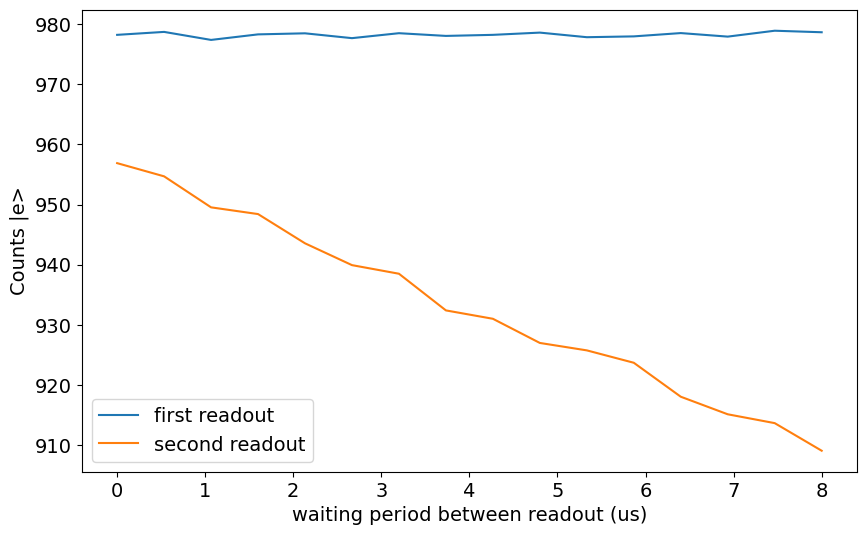

In [86]:
plt.plot(wait_list, first, label='first readout')
plt.plot(wait_list, second, label='second readout')
plt.xlabel('waiting period between readout (us)')
plt.ylabel('Counts |e>')
plt.legend()

### Pi pulse before next readout

In [89]:
chi_calibration = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"small_chi__calibration",
    config_file=config_path,
)

wait_list = np.linspace(0.0, 8.0, 16)

first = []
second = []

for tt in wait_list:

    chi_calibration.cfg.expt = dict(
        cavity_name = 0,   # displaced cavity name
        phase_start=-50,   # cavity displacement phase sweep in deg
        phase_step=2,
        phase_expts=51,
        displace_sigma = 0.05,  # cavity displace length in us
        displace_gain = 0,
        tp = 0.1,  # waiting time us
        # expts=1,  # not used but required for Raverage program
        # start=0,  # not used but required for Raverage program
        # step=1,   # not used but required for Raverage program
        reps=1000,
        # rounds=10,
        qubits=[0],
        pulse_ge = True,   # Whether to pulse qubit to |e> for the calibration
        displace_number = 1,  # How many repeat time of cavity displacement
        wait_time_r = tt   # wait time between readout in us
        )


    print(chi_calibration.cfg)

    import Pyro4.util
    try:
        chi_calibration.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
    selected_results = []
    now_count_list = []
    now_sum_list = []
    for i in range(len(phi_list)):
        now_sum = 0
        now_counts = 0
        for j in range(len(chi_calibration.data['i0'][0][0])):
            #  check if the counts are the same as initial counts
            if chi_calibration.cfg.expt['pulse_ge']:
                if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
            else:
                if chi_calibration.data['i0'][i][0][j]<chi_calibration.cfg.device.readout.threshold[0]: # classified as g
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
        selected_results.append(now_sum/now_counts)
        now_count_list.append(now_counts)
        now_sum_list.append(now_sum)

    first.append(np.average(now_count_list))
    second.append(np.average(now_sum_list))

    

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': 'gauss'}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]]

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

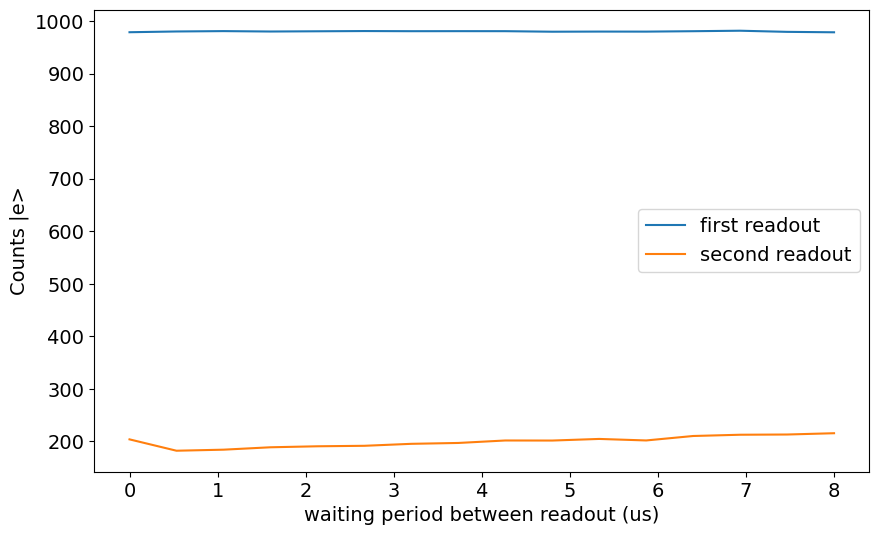

In [88]:
plt.plot(wait_list, first, label='first readout')
plt.plot(wait_list, second, label='second readout')
plt.xlabel('waiting period between readout (us)')
plt.ylabel('Counts |e>')
plt.legend()

In [92]:
chi_calibration = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"small_chi__calibration",
    config_file=config_path,
)

wait_list = np.linspace(0.0, 8.0, 16)

first = []
second = []

for tt in wait_list:

    chi_calibration.cfg.expt = dict(
        cavity_name = 0,   # displaced cavity name
        phase_start=-50,   # cavity displacement phase sweep in deg
        phase_step=2,
        phase_expts=51,
        displace_sigma = 0.05,  # cavity displace length in us
        displace_gain = 0,
        tp = 0.1,  # waiting time us
        # expts=1,  # not used but required for Raverage program
        # start=0,  # not used but required for Raverage program
        # step=1,   # not used but required for Raverage program
        reps=1000,
        # rounds=10,
        qubits=[0],
        pulse_ge = False,   # Whether to pulse qubit to |e> for the calibration
        displace_number = 1,  # How many repeat time of cavity displacement
        wait_time_r = tt   # wait time between readout in us
        )


    print(chi_calibration.cfg)

    import Pyro4.util
    try:
        chi_calibration.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
    selected_results = []
    now_count_list = []
    now_sum_list = []
    for i in range(len(phi_list)):
        now_sum = 0
        now_counts = 0
        for j in range(len(chi_calibration.data['i0'][0][0])):
            #  check if the counts are the same as initial counts
            if chi_calibration.cfg.expt['pulse_ge']:
                if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
            else:
                if chi_calibration.data['i0'][i][0][j]<chi_calibration.cfg.device.readout.threshold[0]: # classified as g
                    now_counts +=1
                    if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:
                        now_sum += 1
        selected_results.append(now_sum/now_counts)
        now_count_list.append(now_counts)
        now_sum_list.append(now_sum)

    first.append(np.average(now_count_list))
    second.append(np.average(now_sum_list))

    

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': 'gauss'}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]]

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': ['gauss']}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': ['gauss'], 'repeat_no': [1]}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': ['gauss']}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': ['gauss']}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': ['gauss']}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': [2866.27], 'cycles_add_to_R': [400]}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.

  0%|          | 0/51 [00:00<?, ?it/s]

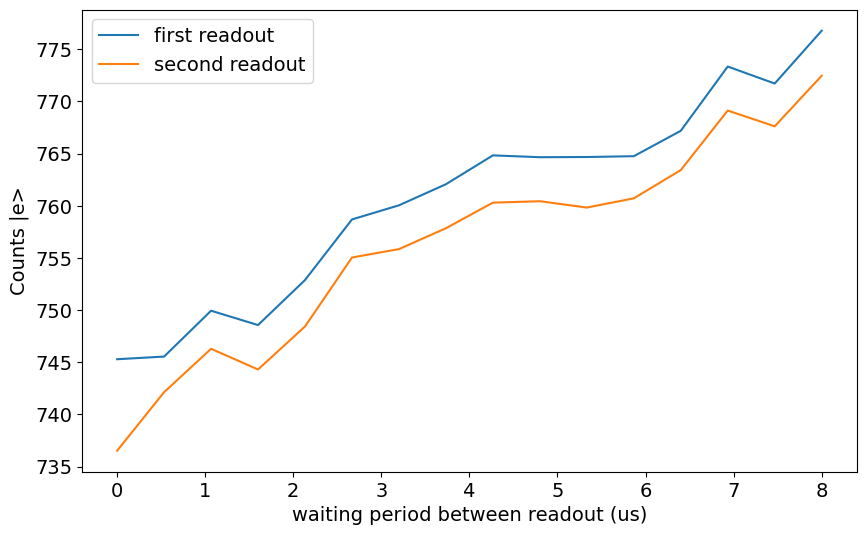

In [93]:
plt.plot(wait_list, first, label='first readout')
plt.plot(wait_list, second, label='second readout')
plt.xlabel('waiting period between readout (us)')
plt.ylabel('Counts |e>')
plt.legend()

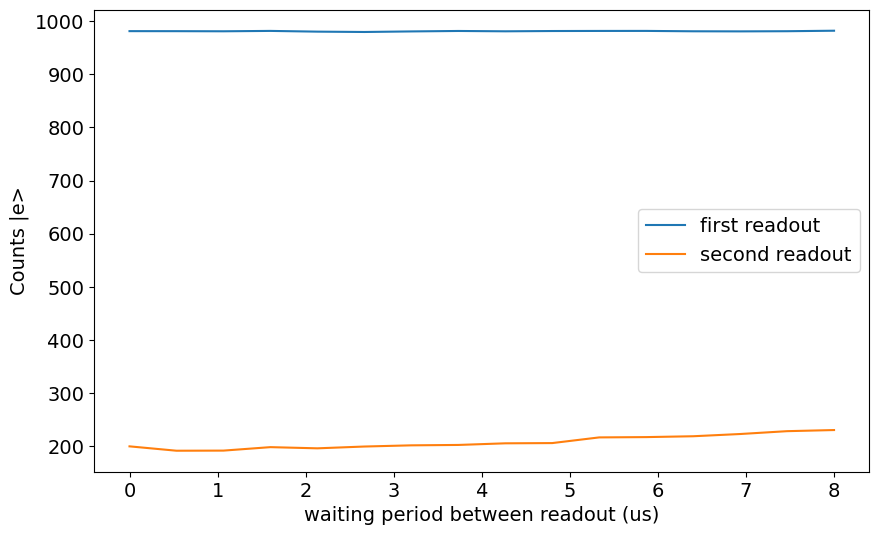

In [91]:
plt.plot(wait_list, first, label='first readout')
plt.plot(wait_list, second, label='second readout')
plt.xlabel('waiting period between readout (us)')
plt.ylabel('Counts |e>')
plt.legend()

### Manipulate 1 calibration

#### |g>

In [110]:
chi_calibration = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"small_chi__calibration",
    config_file=config_path,
)

gain_list = np.arange(0, 15000, 500)
sweep_data = []

for gain in gain_list:
    print('current gain:', gain)
    chi_calibration.cfg.expt = dict(
        cavity_name = 0,   # displaced cavity name
        phase_start=-180,   # cavity displacement phase sweep in deg
        phase_step=6,
        phase_expts=61,
        displace_sigma = 0.1,  # cavity displace length in us
        displace_gain = gain,
        tp = 0.5,  # waiting time us
        # expts=1,  # not used but required for Raverage program
        # start=0,  # not used but required for Raverage program
        # step=1,   # not used but required for Raverage program
        reps=1000,
        # rounds=10,
        qubits=[0],
        pulse_ge = False,   # Whether to pulse qubit to |e> for the calibration
        displace_number = 5,  # How many repeat time of cavity displacement
        wait_time_r = 2.5   # wait time between readout in us
        )


    print(chi_calibration.cfg)

    import Pyro4.util
    try:
        chi_calibration.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
    selected_results = []
    gg_list = []
    ge_list = []
    eg_list = []
    ee_list = []
    for i in range(len(phi_list)):
        gg = 0
        ge = 0
        eg = 0
        ee = 0
        for j in range(len(chi_calibration.data['i0'][0][0])):
            #  check if the counts are the same as initial counts
            if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
                if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                    ee += 1
                else:
                    eg +=1
            else:  # classified as g
                if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                    ge +=1
                else:
                    gg += 1
        gg_list.append(gg)
        ge_list.append(ge)
        eg_list.append(eg)
        ee_list.append(ee)
        if chi_calibration.cfg.expt['pulse_ge']:
            selected_results.append(ee/(eg+ee))
        else:
            selected_results.append(ge/(ge+gg))
    sweep_data.append(selected_results)

current gain: 0
{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17241], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8649], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': 'gauss'}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04

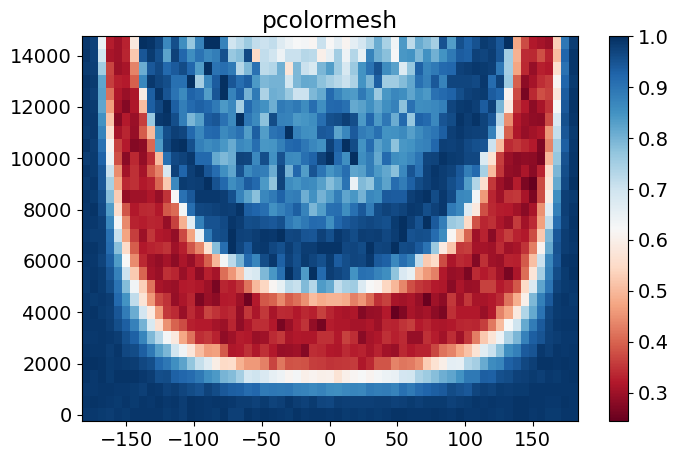

In [111]:
phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
c = axs.pcolormesh(phi_list, gain_list, sweep_data, cmap='RdBu')
axs.set_title('pcolormesh')
fig.colorbar(c, ax=axs)

#### |e>

In [114]:
chi_calibration = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"small_chi__calibration",
    config_file=config_path,
)

gain_list = np.arange(0, 30000, 1000)
sweep_data = []

for gain in gain_list:
    print('current gain:', gain)
    chi_calibration.cfg.expt = dict(
        cavity_name = 0,   # displaced cavity name
        phase_start=-180,   # cavity displacement phase sweep in deg
        phase_step=6,
        phase_expts=61,
        displace_sigma = 0.1,  # cavity displace length in us
        displace_gain = gain,
        tp = 0.5,  # waiting time us
        # expts=1,  # not used but required for Raverage program
        # start=0,  # not used but required for Raverage program
        # step=1,   # not used but required for Raverage program
        reps=1000,
        # rounds=10,
        qubits=[0],
        pulse_ge = True,   # Whether to pulse qubit to |e> for the calibration
        displace_number = 5,  # How many repeat time of cavity displacement
        wait_time_r = 2.5   # wait time between readout in us
        )


    print(chi_calibration.cfg)

    import Pyro4.util
    try:
        chi_calibration.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
    selected_results = []
    gg_list = []
    ge_list = []
    eg_list = []
    ee_list = []
    for i in range(len(phi_list)):
        gg = 0
        ge = 0
        eg = 0
        ee = 0
        for j in range(len(chi_calibration.data['i0'][0][0])):
            #  check if the counts are the same as initial counts
            if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
                if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                    ee += 1
                else:
                    eg +=1
            else:  # classified as g
                if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                    ge +=1
                else:
                    gg += 1
        gg_list.append(gg)
        ge_list.append(ge)
        eg_list.append(eg)
        ee_list.append(ee)
        if chi_calibration.cfg.expt['pulse_ge']:
            selected_results.append(ee/(eg+ee))
        else:
            selected_results.append(ge/(ge+gg))
    sweep_data.append(selected_results)

current gain: 0
{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.1534332340225], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17241], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8649], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [4389], 'sigma': [0.1], 'type': 'gauss'}, 'hpi_ef': {'gain': [2295], 'sigma': [0.1], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04

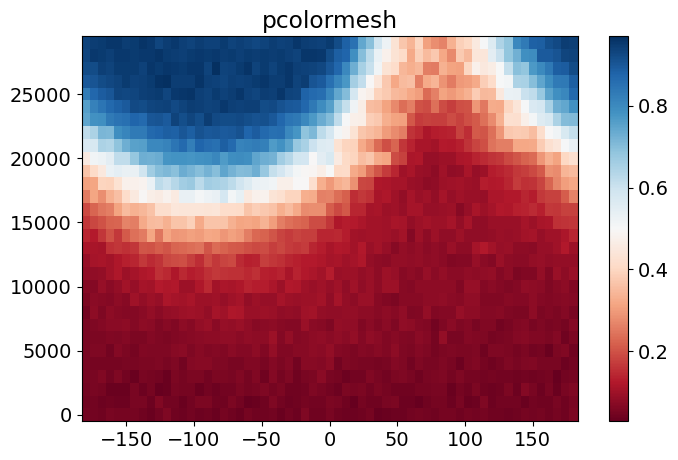

In [115]:
phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
c = axs.pcolormesh(phi_list, gain_list, sweep_data, cmap='RdBu')
axs.set_title('pcolormesh')
fig.colorbar(c, ax=axs)

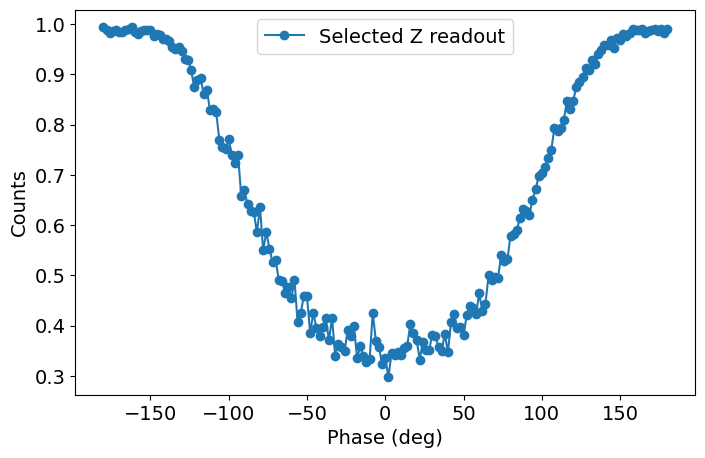

In [94]:
# initial = |g>
phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
selected_results = []
gg_list = []
ge_list = []
eg_list = []
ee_list = []
for i in range(len(phi_list)):
    gg = 0
    ge = 0
    eg = 0
    ee = 0
    for j in range(len(chi_calibration.data['i0'][0][0])):
        #  check if the counts are the same as initial counts
        if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ee += 1
            else:
                eg +=1
        else:  # classified as g
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ge +=1
            else:
                gg += 1
    gg_list.append(gg)
    ge_list.append(ge)
    eg_list.append(eg)
    ee_list.append(ee)
    if chi_calibration.cfg.expt['pulse_ge']:
        selected_results.append(ee/(eg+ee))
    else:
        selected_results.append(ge/(ge+gg))
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
axs.plot(phi_list, selected_results, 'o-', label='Selected Z readout')
axs.set_xlabel('Phase (deg)')
axs.set_ylabel('Counts')
axs.legend()


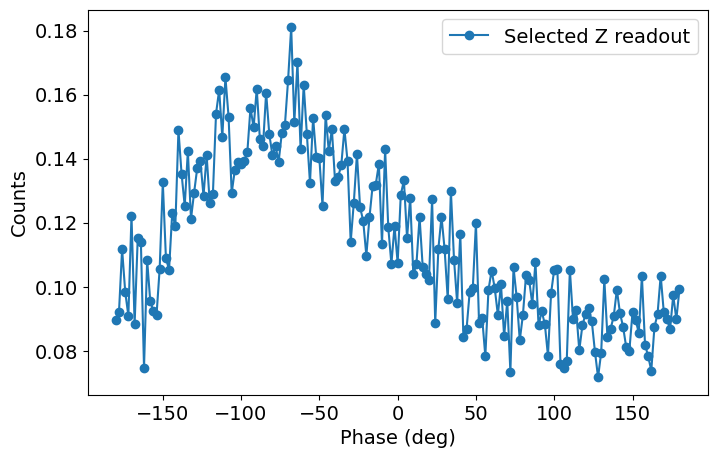

In [100]:
# initial=|e>
phi_list = chi_calibration.cfg.expt["phase_start"] + chi_calibration.cfg.expt["phase_step"] * np.arange(chi_calibration.cfg.expt["phase_expts"])
selected_results = []
gg_list = []
ge_list = []
eg_list = []
ee_list = []
for i in range(len(phi_list)):
    gg = 0
    ge = 0
    eg = 0
    ee = 0
    for j in range(len(chi_calibration.data['i0'][0][0])):
        #  check if the counts are the same as initial counts
        if chi_calibration.data['i0'][i][0][j]>chi_calibration.cfg.device.readout.threshold[0]: # classified as e
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ee += 1
            else:
                eg +=1
        else:  # classified as g
            if chi_calibration.data['i0'][i][1][j]>chi_calibration.cfg.device.readout.threshold[0]:  # second e
                ge +=1
            else:
                gg += 1
    gg_list.append(gg)
    ge_list.append(ge)
    eg_list.append(eg)
    ee_list.append(ee)
    if chi_calibration.cfg.expt['pulse_ge']:
        selected_results.append(ee/(eg+ee))
    else:
        selected_results.append(ge/(ge+gg))
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
axs.plot(phi_list, selected_results, 'o-', label='Selected Z readout')
axs.set_xlabel('Phase (deg)')
axs.set_ylabel('Counts')
axs.legend()


In [103]:
np.arange(0, 15000, 500)

array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
        4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
        9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
       13500, 14000, 14500])

## Calibrate alpha vs. displace voltage, using enclosed phase offset

################### qubit pi/2 phase=0 --> cavity displace in total 4 pulses ---> qubit pi/2 phase=0
################### qubit pi/2 phase=0 --> cavity displace in total 4 pulses ---> qubit pi/2 phase=90


### Manipulate1 calibration

In [79]:
displace1 = meas.DisplaceCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"displacement_calibration",
    config_file=config_path,
)

displace1.cfg.expt = dict(
    cavity_name = 0,   # displaced cavity name
    guessed_chi = -0.34,   # cavity chi shift (uncalibrated)
    gain_start=0,   # cavity displacement gain sweep
    gain_step=200,
    gain_expts=51,
    displace_sigma = 21,  # number of cycles, 2 sigma Gaussian pulse
    tp = 86,  # waiting time cycles
    reps=100,
    rounds=10,
    qubits=[0],
    repeat_time = 5,
    check_type = 'X'   # X or Y, X: last qubit rotation same phase, Y: last qubit rotation +90 phase
    )
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(displace1.cfg)

import Pyro4.util
try:
    displace1.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'gain

  0%|          | 0/51 [00:00<?, ?it/s]

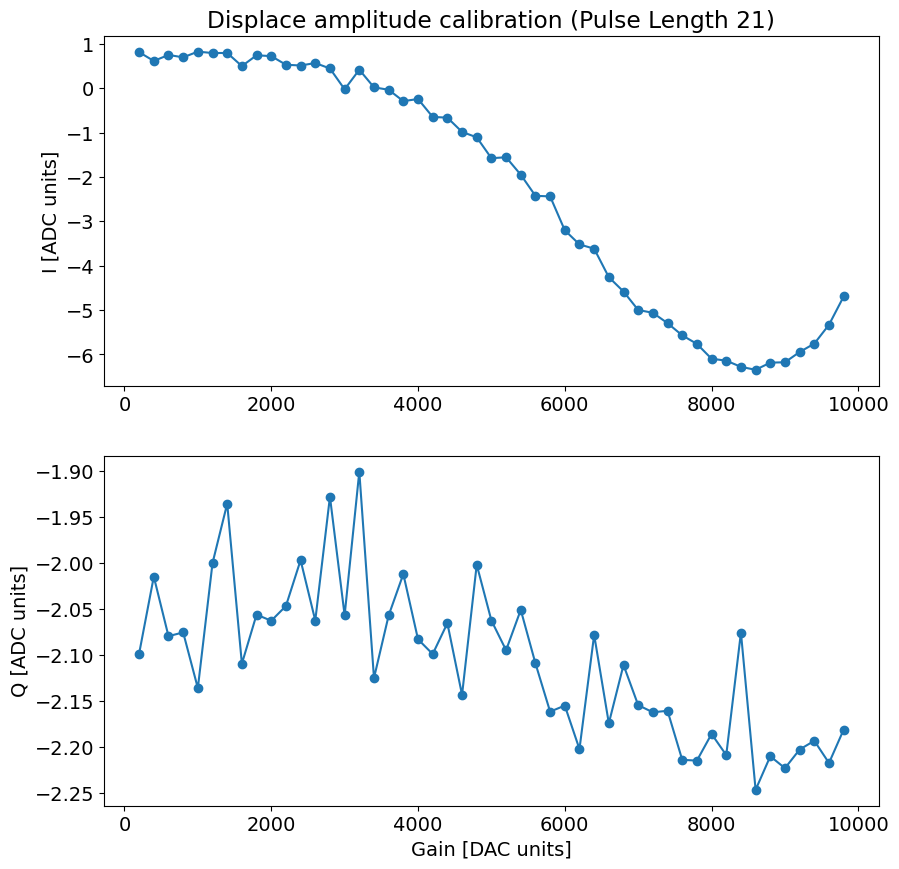

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00026_displacement_calibration.h5


In [80]:

displace1.analyze(fit=False)
displace1.display(fit=False)
displace1.save_data()

In [81]:
displace1 = meas.DisplaceCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"displacement_calibration",
    config_file=config_path,
)

displace1.cfg.expt = dict(
    cavity_name = 0,   # displaced cavity name
    guessed_chi = -0.34,   # cavity chi shift (uncalibrated)
    gain_start=0,   # cavity displacement gain sweep
    gain_step=200,
    gain_expts=51,
    displace_sigma = 21,  # number of cycles, 2 sigma Gaussian pulse
    tp = 86,  # waiting time cycles
    reps=100,
    rounds=10,
    qubits=[0],
    repeat_time = 5,
    check_type = 'Y'   # X or Y, X: last qubit rotation same phase, Y: last qubit rotation +90 phase
    )
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(displace1.cfg)

import Pyro4.util
try:
    displace1.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'gain

  0%|          | 0/51 [00:00<?, ?it/s]

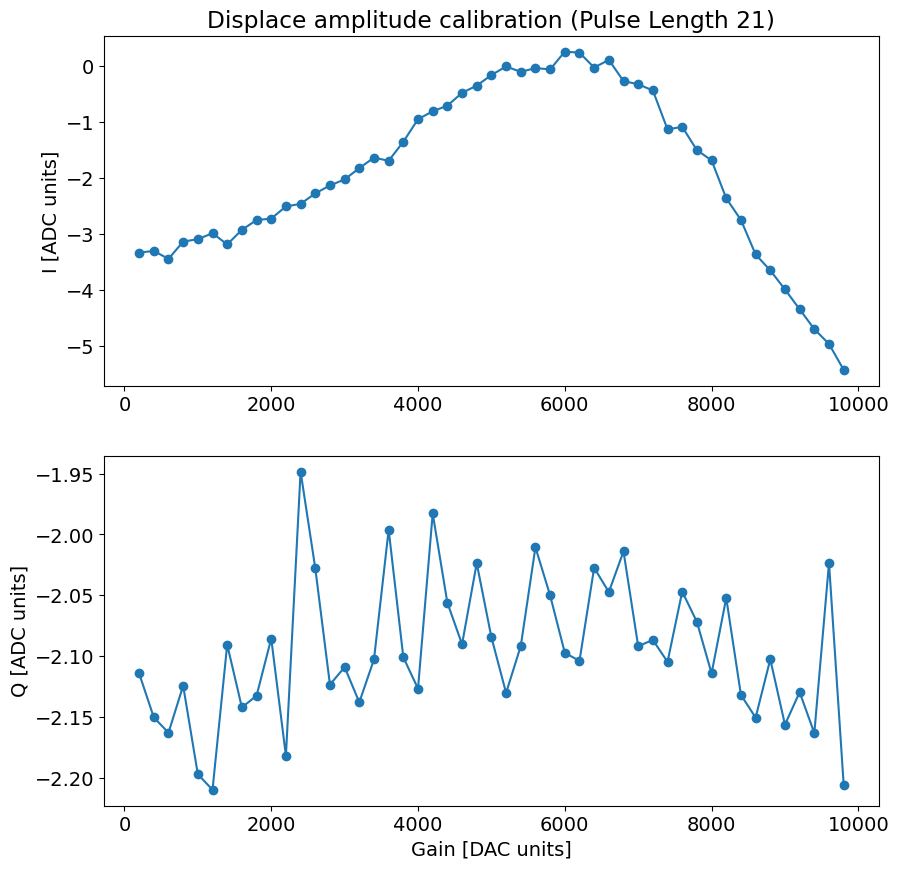

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00027_displacement_calibration.h5


In [82]:

displace1.analyze(fit=False)
displace1.display(fit=False)
displace1.save_data()

### Manipulate 2

In [92]:
displace1 = meas.DisplaceCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"displacement_calibration",
    config_file=config_path,
)

displace1.cfg.expt = dict(
    cavity_name = 1,   # displaced cavity name
    guessed_chi = -0.19,   # cavity chi shift (uncalibrated)
    gain_start=0,   # cavity displacement gain sweep
    gain_step=200,
    gain_expts=51,
    displace_sigma = 41,  # number of cycles, 2 sigma Gaussian pulse
    tp = 86,  # waiting time cycles
    reps=100,
    rounds=10,
    qubits=[0],
    repeat_time = 5,
    check_type = 'X'   # X or Y, X: last qubit rotation same phase, Y: last qubit rotation +90 phase
    )
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(displace1.cfg)

import Pyro4.util
try:
    displace1.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'gain

  0%|          | 0/51 [00:00<?, ?it/s]

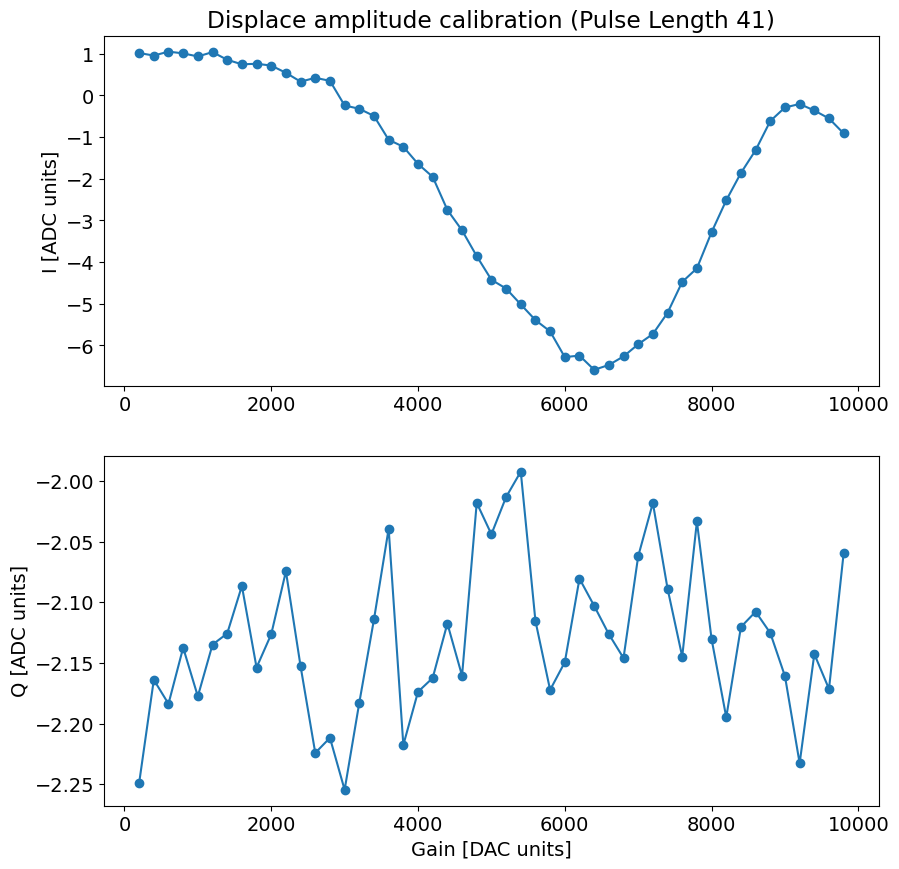

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00032_displacement_calibration.h5


In [93]:

displace1.analyze(fit=False)
displace1.display(fit=False)
displace1.save_data()

In [88]:
displace1 = meas.DisplaceCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"displacement_calibration",
    config_file=config_path,
)

displace1.cfg.expt = dict(
    cavity_name = 1,   # displaced cavity name
    guessed_chi = -0.19,   # cavity chi shift (uncalibrated)
    gain_start=0,   # cavity displacement gain sweep
    gain_step=200,
    gain_expts=51,
    displace_sigma = 41,  # number of cycles, 2 sigma Gaussian pulse
    tp = 86,  # waiting time cycles
    reps=100,
    rounds=10,
    qubits=[0],
    repeat_time = 5,
    check_type = 'Y'   # X or Y, X: last qubit rotation same phase, Y: last qubit rotation +90 phase
    )
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(displace1.cfg)

import Pyro4.util
try:
    displace1.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'gain

  0%|          | 0/51 [00:00<?, ?it/s]

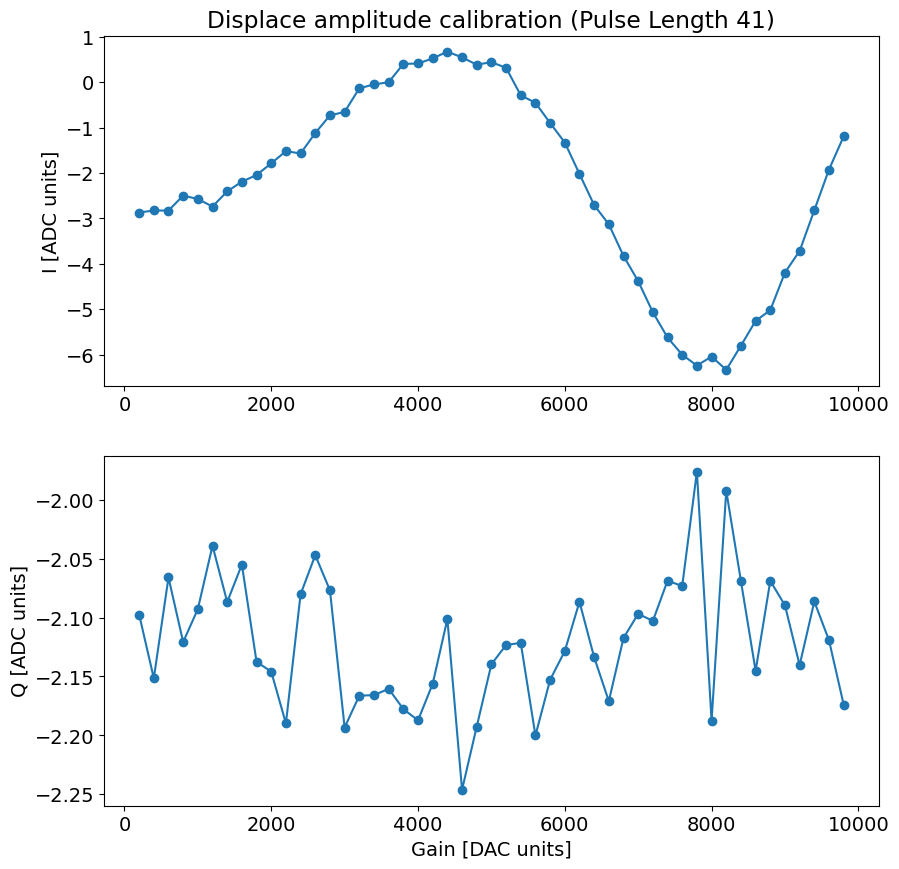

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00030_displacement_calibration.h5


In [89]:

displace1.analyze(fit=False)
displace1.display(fit=False)
displace1.save_data()

########################## 1/step is the total frequency spectrum, 1/step/points is the frequency resolution, adding 0 points can make data look nicer

### Manipulate 1

In [94]:
t2r = meas.DisplaceRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_cavity_displacement",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=0.1, # [MHz]
    reps=50,
    rounds=10,
    qubits=[0],
    cavity_pre_displace = [False, 0, 300, 0.5, 0],   #  [turn on/off, which cavity (0/1), drive amplitude, drive sigma (us), drive phase] (default pulse shape is gaussian)  
    checkEF=False,
    f0g1_cavity=0  #  name of manipulate cavity, 0 means no pulse
)
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.306669288791], 'f_ge_resolved': [3576.306669288791], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [275], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'gain

  0%|          | 0/10 [00:00<?, ?it/s]

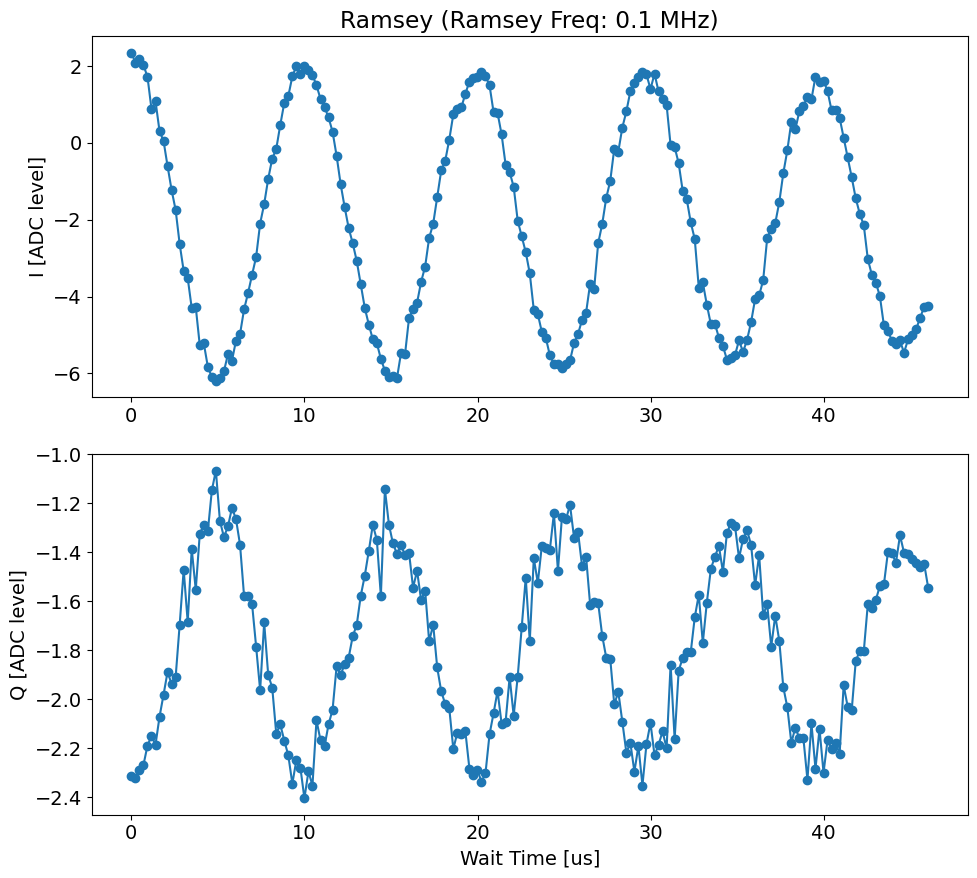

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00024_ramsey_cavity_displacement.h5


'H:\\Shared drives\\multimode\\Multimode\\experiment\\230914\\data\\00024_ramsey_cavity_displacement.h5'

In [95]:

t2r.analyze(fit=False)
t2r.display(fit=False)
t2r.save_data()

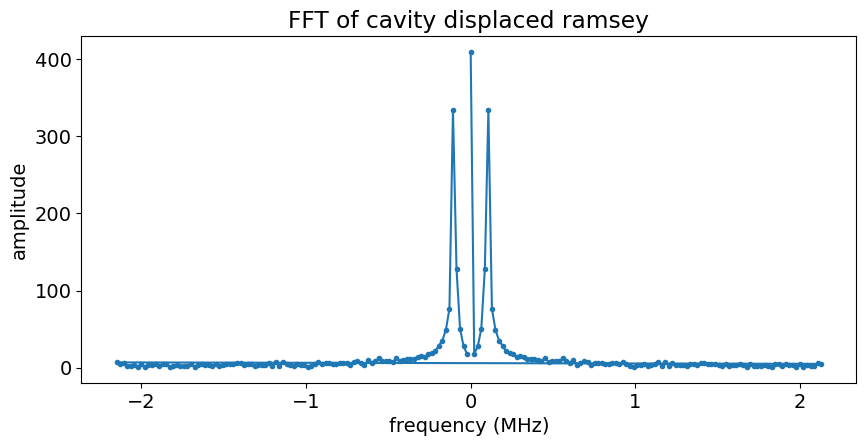

In [96]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


In [110]:
target0=0.0+0.1
idx0 = np.argmin(np.abs(freq - target0))
power0 = np.abs(sp[idx0])

target1=0.34+0.1
idx1 = np.argmin(np.abs(freq - target1))
power1 = np.abs(sp[idx1])

target2=0.19+0.1
idx2 = np.argmin(np.abs(freq - target2))
power2 = np.abs(sp[idx2])

T1 = 15
T1p = 20
T2 = 196

k0 = 1/T2
k1 = 1/T1+1/T2
k2 = 1/T1p+1/T2

k0=1
k1=1
k2=1


print(power0*k0)
print(power1*k1)
print(power2*k2)

333.6563512588485
8.518546963102626
13.355435892081626


In [127]:
t2r = meas.DisplaceRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_cavity_displacement",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=0.1, # [MHz]
    reps=50,
    rounds=10,
    qubits=[0],
    cavity_pre_displace = [True, 0, 300, 0.5, 0],   #  [turn on/off, which cavity (0/1), drive amplitude, drive sigma (us), drive phase] (default pulse shape is gaussian)  
    checkEF=False,
    f0g1_cavity=0  #  name of manipulate cavity, 0 means no pulse
)
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.2897678235267], 'f_ge_resolved': [3576.2897678235267], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'ga

  0%|          | 0/10 [00:00<?, ?it/s]

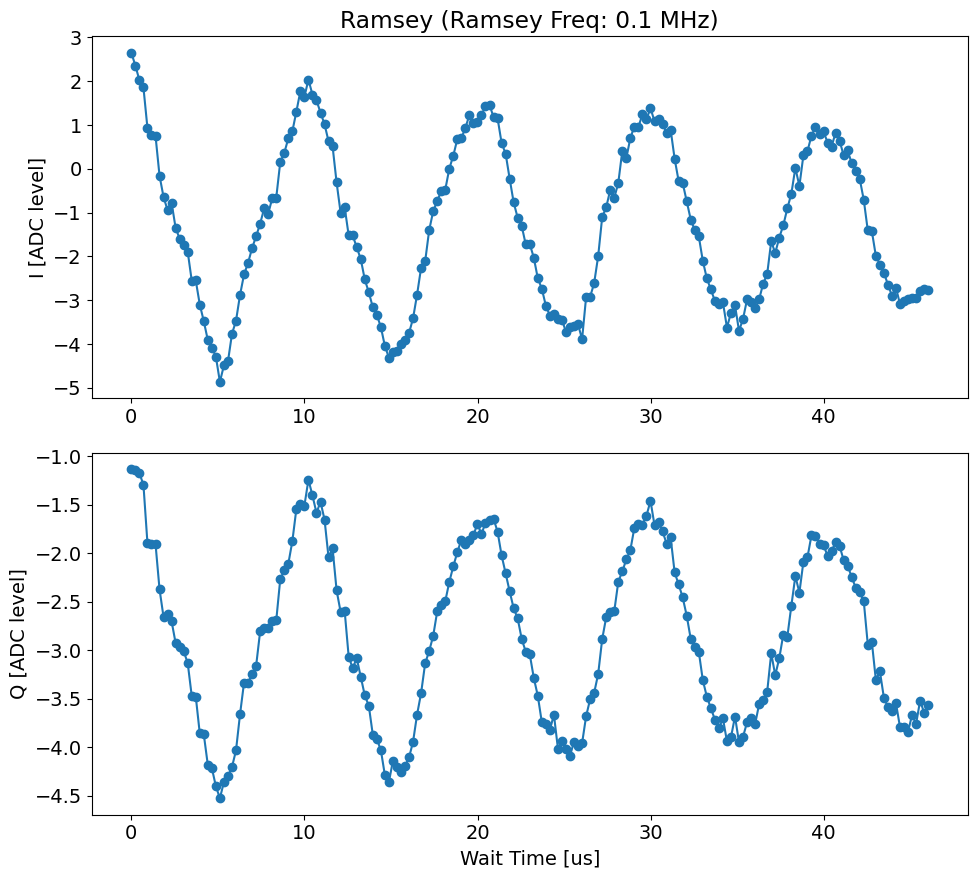

Saving H:\My Drive\My project\Multimode\experiment\230914\data\00016_ramsey_cavity_displacement.h5


'H:\\My Drive\\My project\\Multimode\\experiment\\230914\\data\\00016_ramsey_cavity_displacement.h5'

In [128]:

t2r.analyze(fit=False)
t2r.display(fit=False)
t2r.save_data()

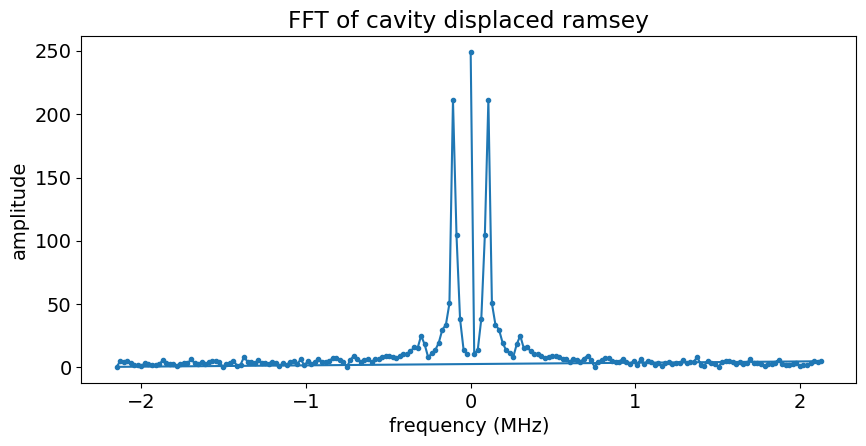

In [129]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


In [130]:
t2r = meas.DisplaceRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_cavity_displacement",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=0.0, # [MHz]
    reps=50,
    rounds=10,
    qubits=[0],
    cavity_pre_displace = [True, 0, 1000, 0.5, 0],   #  [turn on/off, which cavity (0/1), drive amplitude, drive sigma (us), drive phase] (default pulse shape is gaussian)  
    checkEF=False,
    f0g1_cavity=0  #  name of manipulate cavity, 0 means no pulse
)
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.2897678235267], 'f_ge_resolved': [3576.2897678235267], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'ga

  0%|          | 0/10 [00:00<?, ?it/s]

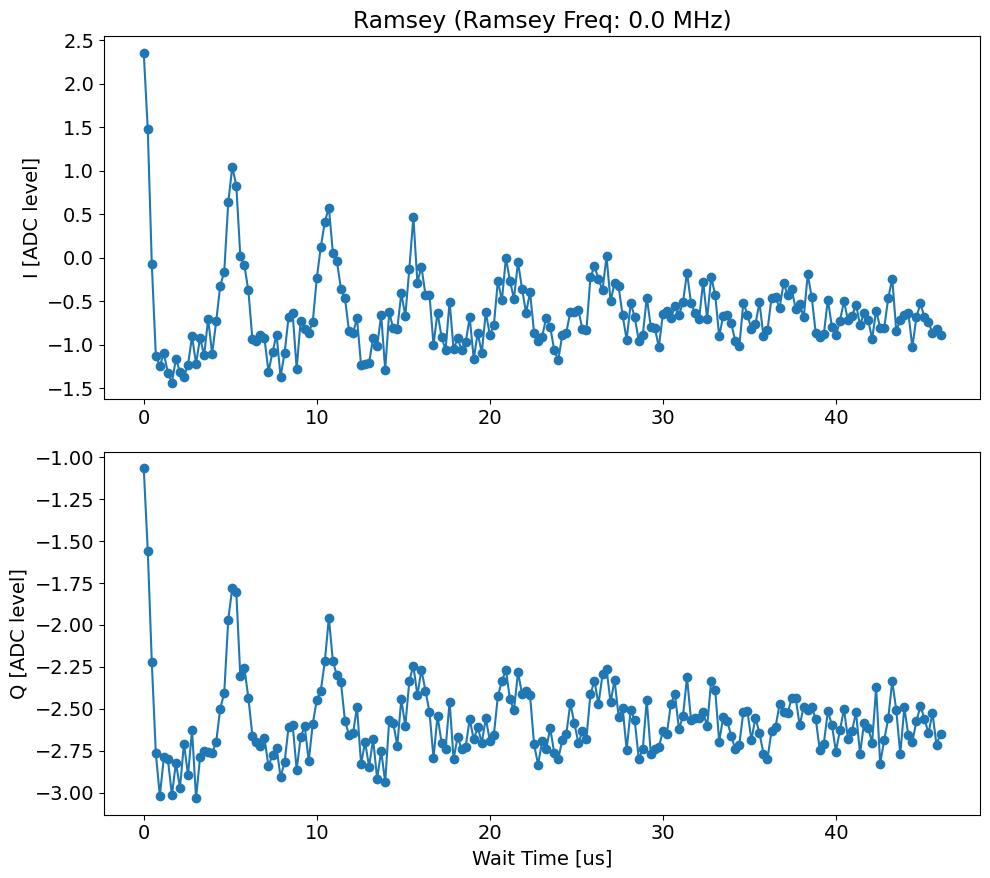

In [136]:

t2r.analyze(fit=False)
t2r.display(fit=False)
# t2r.save_data()

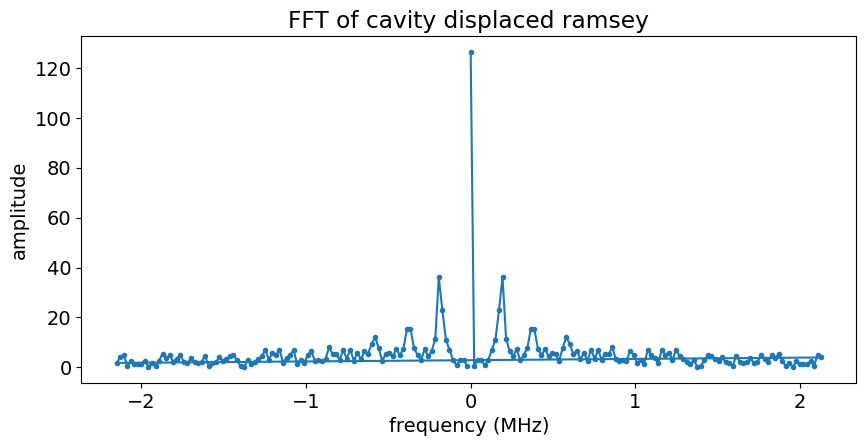

In [137]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
# plt.yscale('log')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


In [138]:
t2r = meas.DisplaceRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_cavity_displacement",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=0.0, # [MHz]
    reps=50,
    rounds=10,
    qubits=[0],
    cavity_pre_displace = [True, 0, 1500, 0.5, 0],   #  [turn on/off, which cavity (0/1), drive amplitude, drive sigma (us), drive phase] (default pulse shape is gaussian)  
    checkEF=False,
    f0g1_cavity=0  #  name of manipulate cavity, 0 means no pulse
)
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.2897678235267], 'f_ge_resolved': [3576.2897678235267], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'ga

  0%|          | 0/10 [00:00<?, ?it/s]

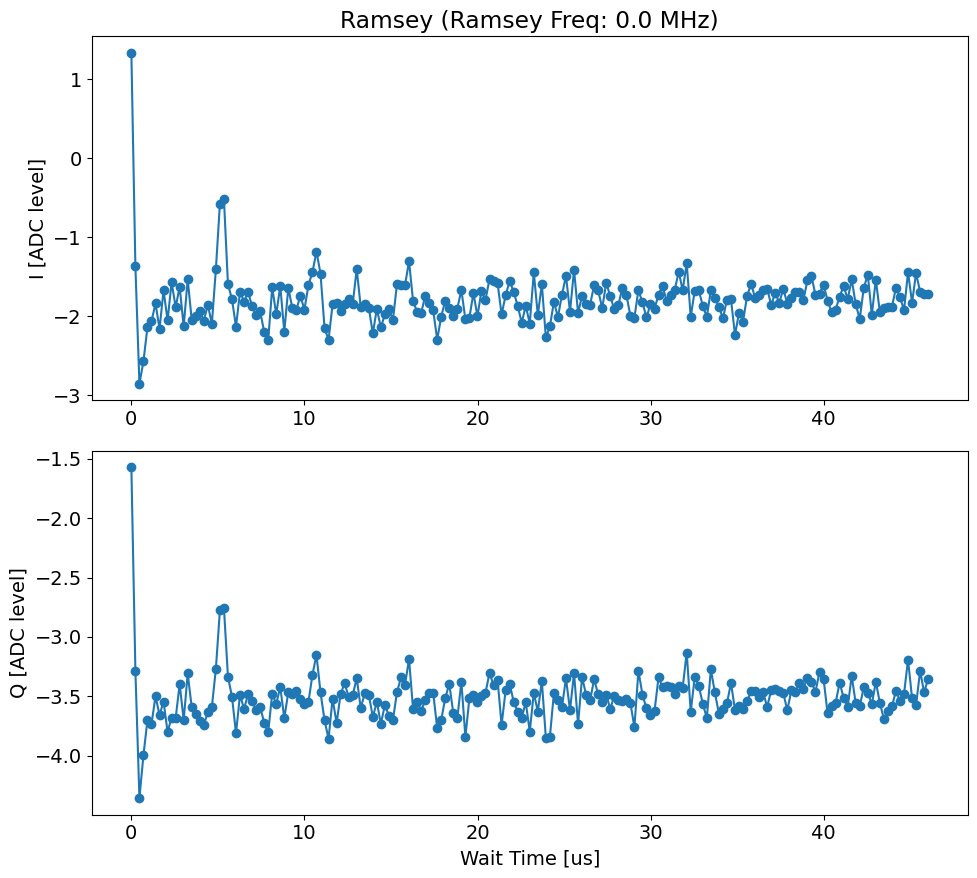

Saving H:\My Drive\My project\Multimode\experiment\230914\data\00018_ramsey_cavity_displacement.h5


'H:\\My Drive\\My project\\Multimode\\experiment\\230914\\data\\00018_ramsey_cavity_displacement.h5'

In [139]:

t2r.analyze(fit=False)
t2r.display(fit=False)
t2r.save_data()

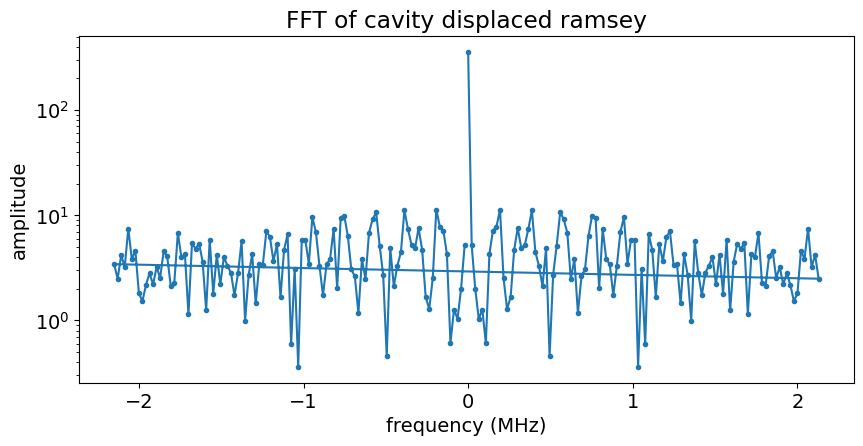

In [143]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
plt.yscale('log')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


## Manipulate 2

In [25]:
t2r = meas.DisplaceRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_cavity_displacement",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(100), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=201,
    ramsey_freq=0.1, # [MHz]
    reps=100,
    rounds=10,
    qubits=[0],
    cavity_pre_displace = [True, 1, 1000, 0.5, 0],   #  [turn on/off, which cavity (0/1), drive amplitude, drive sigma (us), drive phase] (default pulse shape is gaussian)  
    checkEF=False,
    f0g1_cavity=0  #  name of manipulate cavity, 0 means no pulse
)
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [4008.1862087958075], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3576.2897678235267], 'f_ge_resolved': [3576.2897678235267], 'f_ef': [3434.356201991663], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17176], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [301], 'sigma': [2], 'type': 'gauss', 'repeat_no': 1}, 'hpi_ge': {'gain': [8717], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [10053], 'sigma': [0.04441286769734369], 'type': 'gauss'}, 'hpi_ef': {'gain': [5026], 'sigma': [0.04], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852]}}, 'f0g1': 2866.27, 'cycles_add_to_R': 400}, 'QM': {'chi_shift_matrix': [[-127.7640198, -0.0, -0.0], [-0.0, 0.0, 0.0], [-0.0, 0.0, 0.0]], 'pulses': {'qubit_pi_ge': {'gain': [[17176, 17176], [17176, 17176]], 'sigma': [[0.04, 0.04], [0.04, 0.04]], 'type': 'gauss'}, 'qubit_pi_ge_resolved': {'ga

  0%|          | 0/10 [00:00<?, ?it/s]

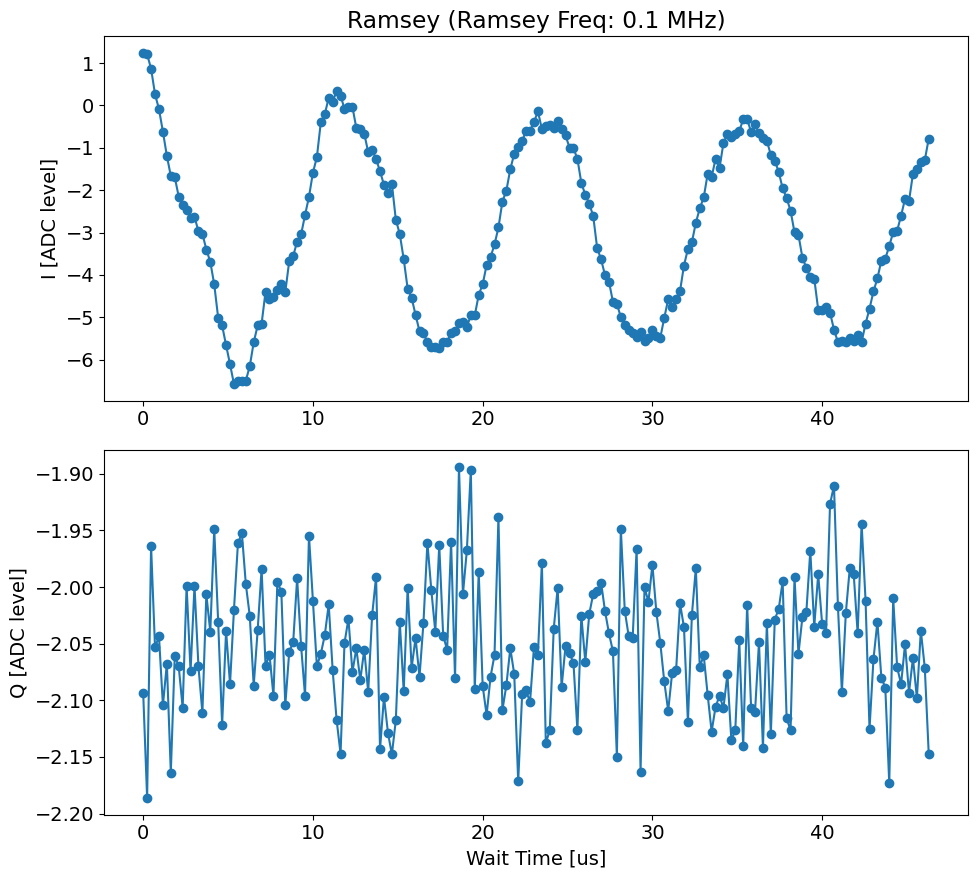

Saving H:\Shared drives\multimode\Multimode\experiment\230914\data\00023_ramsey_cavity_displacement.h5


'H:\\Shared drives\\multimode\\Multimode\\experiment\\230914\\data\\00023_ramsey_cavity_displacement.h5'

In [26]:


t2r.analyze(fit=False)
t2r.display(fit=False)
t2r.save_data()

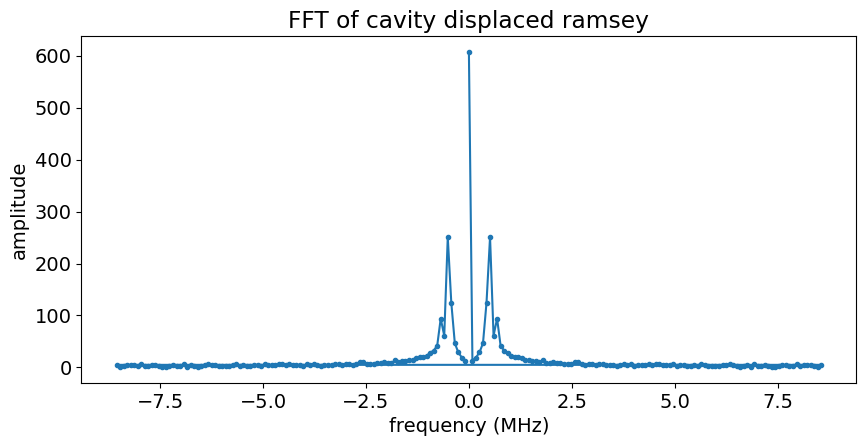

In [23]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
# plt.yscale('log')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


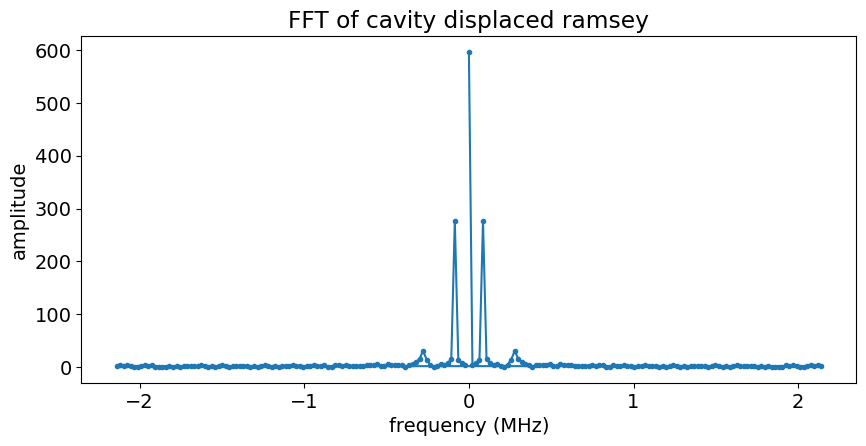

In [27]:
data = t2r.analyze(fit=False)
t = data['xpts']
sp = np.fft.fft(data['avgi'])
freq = np.fft.fftfreq(t.shape[-1])/(data['xpts'][1]-data['xpts'][0])
title = 'FFT of cavity displaced ramsey'
plt.figure(figsize=(10,4.5))
plt.subplot(111, 
            title=title,
            ylabel="amplitude",
            xlabel="frequency (MHz)")
plt.plot(freq, np.abs(sp),'.-')
# plt.yscale('log')
plt.show()
# To include the exponential decay, we only need pick the obvious peak point (or basically pick every points nearest to chi*n), then let An=abs(peak amplitude)^2*kn^2, here kn=1/T2+n/T1 (T2= qubit, T1=cavity, n=cavity fock state)


# Standard Wigner tomography

## Manipulate 1

In [18]:
qubit_pulse_filename = './/optimal control//20240222_qubit_optimal.npy'
cavity_pulse_filename = './/optimal control//20240222_cavity_optimal.npy'

wigner_exp = meas.WignerTomography1ModeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"Wigner_tomography",
    config_file=config_path,
)

# alpha_list = np.arange(0,6.1,0.3)
# gain_list = [int(x/0.000239708) for x in alpha_list]

wigner_exp.cfg.expt = dict(
    gain2alpha = 0.001148213,
    cavity_name = 0,   # displaced cavity name
    displace_length = 1,    # displace length in us, pulse shape is gaussian
    I_list = np.linspace(-5.0,5.0,21),    #  displace gain
    Q_list = np.linspace(-5.0,5.0,21),   # in deg
    prepulse = False,
    pre_sweep_pulse = [[3568.7888873838688],
                       [17410],
                       [0.0],
                       [0],
                       [2],['gaussian'], 
                       [1]],
    # pre_sweep_pulse = [[3568.7888873838688, 3426.163873165147, 2010.5265269004717],
    #                    [17410, 6537,  20000],
    #                    [0.0,0.0, 7.798084629167243],
    #                    [0,0,0],
    #                    [2,2,2],['gaussian','gaussian','flat_top'], 
    #                    [0.04,0.08, 0.005]],
    # pre_sweep_pulse = [[4984.533795427038, 1, 337.4],[2000, 0,  8000],[2.0,3.0, 0.23581121290573867],[0,0,0],[6,6,1],['flat_top','const','flat_top'], [0.01,0, 0.01]],   # pre pulses shapes and sigma length (if used) flat_top, const, gaussian
                                            # [[frequency], [gain], [length (us)], [phases], [drive channel]], drive channel=1 (flux low), 2 (qubit), 3 (flux high),4 (storage),5 (flux storage),6 (manipulate),           
    reps=2000,
    qubits=[0],
    optpulse = False,
    opt_freq = [3568.7888873838688, 4984.376405764741],
    # opt_gain = [int(qubit_gain*Gaussian_pi_gain/np.sqrt(2)), int(cavity_gain/gain2alpha/np.sqrt(2))],
    opt_gain = [1,1],
    opt_delay_start = [0, 260],   # in cycles
    opt_file_path= [qubit_pulse_filename, cavity_pulse_filename]
    )


print(wigner_exp.cfg)

import Pyro4.util
try:
    wigner_exp.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [3568.7888873838688], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.7888873838688], 'f_ge_resolved': [3568.7888873838688], 'f_ef': [3426.163873165147], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17410], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [72], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8874], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6537], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3270], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [19]:
wigner_exp.save_data()

Saving H:\Shared drives\multimode\Multimode\experiment\240205\data\00021_Wigner_tomography.h5


Text(0, 0.5, 'Wigner Function')

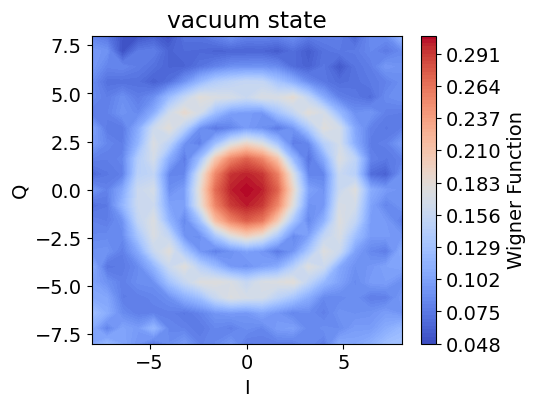

In [21]:
temp_data1, attrs1 = prev_data(expt_path, '00017_Wigner_tomography.h5') 
I_list = np.linspace(-8.0,8.0,21)
Q_list = np.linspace(-8.0,8.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('vacuum state')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

Text(0, 0.5, 'Wigner Function')

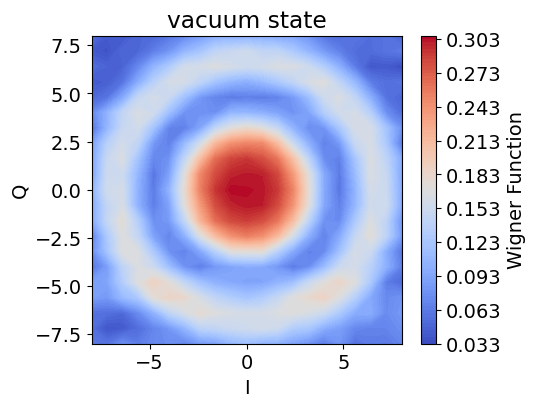

In [20]:
temp_data1, attrs1 = prev_data(expt_path, '00021_Wigner_tomography.h5') 
I_list = np.linspace(-8.0,8.0,21)
Q_list = np.linspace(-8.0,8.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('vacuum state')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

### initial state

Text(0, 0.5, 'Wigner Function')

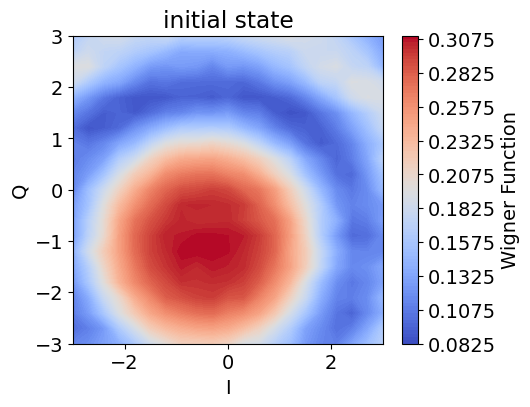

In [68]:
temp_data1, attrs1 = prev_data(expt_path, '00008_Wigner_tomography.h5') 
I_list = np.linspace(-3.0,3.0,21)
Q_list = np.linspace(-3.0,3.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('initial state')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

In [69]:
aa = np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)])
from numpy import unravel_index
unravel_index(aa.argmax(), aa.shape)

(6, 8)

### pi swaped displaced state

Text(0, 0.5, 'Wigner Function')

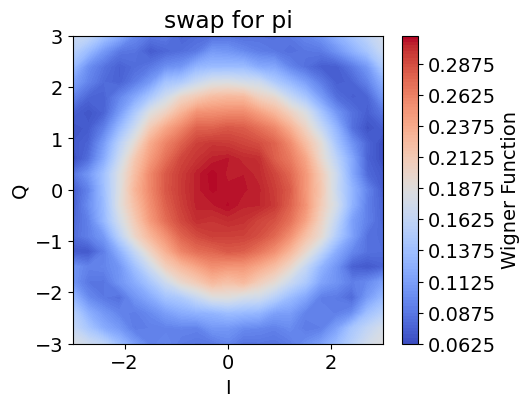

In [62]:
temp_data1, attrs1 = prev_data(expt_path, '00010_Wigner_tomography.h5') 
I_list = np.linspace(-3.0,3.0,21)
Q_list = np.linspace(-3.0,3.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('swap for pi')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

In [64]:
aa = np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)])
from numpy import unravel_index
unravel_index(aa.argmax(), aa.shape)

(11, 9)

### 2pi swaped displaced state

Text(0, 0.5, 'Wigner Function')

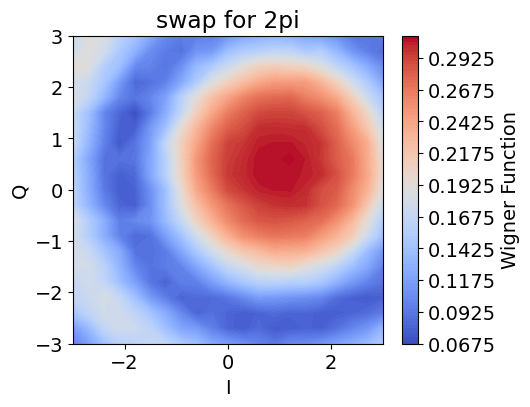

In [66]:
temp_data1, attrs1 = prev_data(expt_path, '00009_Wigner_tomography.h5') 
I_list = np.linspace(-3.0,3.0,21)
Q_list = np.linspace(-3.0,3.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('swap for 2pi')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

In [67]:
aa = np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)])
from numpy import unravel_index
unravel_index(aa.argmax(), aa.shape)

(12, 14)

Text(0, 0.5, 'Wigner Function')

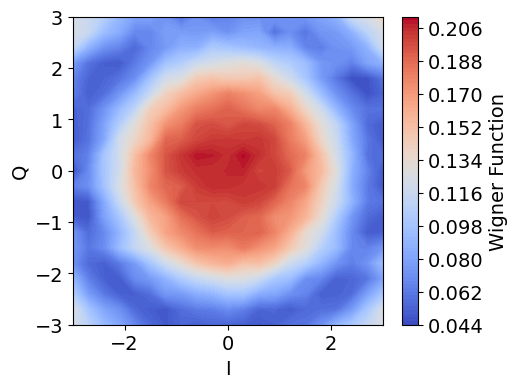

In [18]:
temp_data1, attrs1 = prev_data(expt_path, '00001_Wigner_tomography.h5') 
I_list = np.linspace(-3.0,3.0,21)
Q_list = np.linspace(-3.0,3.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')

# ECD Calibration

## Out and Back Measurement
Displace-> Displace back with phase-> check where cavity at 0

In [12]:
out_back = meas.OutBackMeasurementExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"OutBack",
    config_file=config_path,
)


In [13]:
out_back.cfg.expt = dict(
    cavity_name = 0,   # displaced cavity name
    phase_start = 0.0,
    phase_step = 0.01,
    phase_expts = 30,
    reps=2000,
    # rounds=10,
    qubits=[0],
    displace_number = 1, 
    displace_gain = 30000,
    displace_sigma = 0.011, # in mu s
    tp = 1, #wait time between displacements (in mus)
    wait_time_r = 0.1, # wait time between measurements (in mus)
    pulse_ge = False,   # Whether to flip qubit ge as initialization
    )

In [14]:
print(out_back.cfg)
#out_back.go(analyze=False, display=False, progress=True, save=False)

# To get error messages
import Pyro4.util
try:
    out_back.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [3568.7875139436787], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.7875139436787], 'f_ge_resolved': [3568.7875139436787], 'f_ef': [3426.154986272321], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17366], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [73], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8592], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6639], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3441], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
out_back.save_data()

Saving E:\Shared drives\multimode\Multimode\experiment\240205\data\00002_OutBack.h5


Text(0.5, 1.0, 'Displace Gain: 30000')

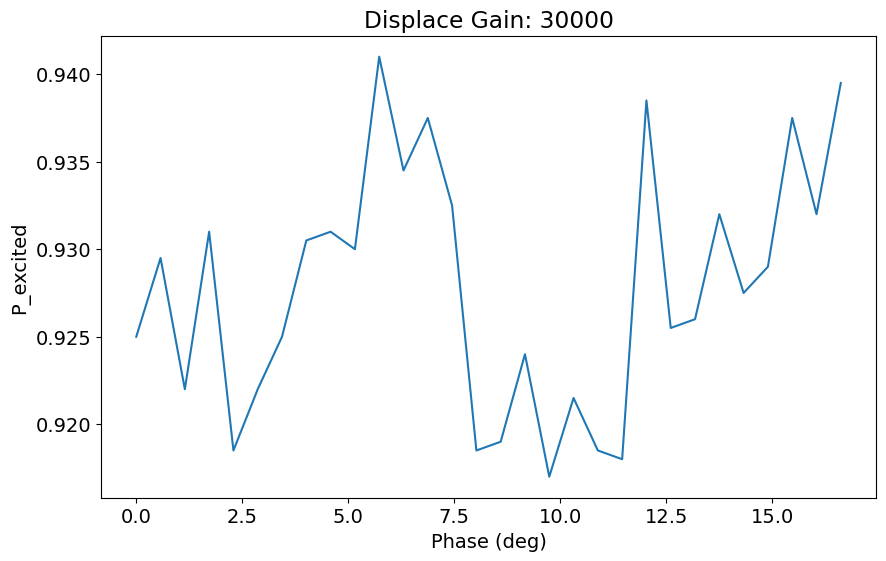

In [17]:
temp_data1, attrs1 = prev_data(expt_path, '00002_OutBack.h5') 
# I_list = np.linspace(-12.0,12.0,21)
# Q_list = np.linspace(-12.0,12.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]

allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    #for each phase data point
    counts = 0
    counts_post_selected = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        #for each count 
        #if qubit still in initial state 
        counts_post_selected+=1
        if temp_data1['i0'][ii][0][jj] < tre: # qubit grounded (performing post selection)
            if temp_data1['i0'][ii][1][jj] > tre: 
                counts += 1
    allocated_readout.append(counts/counts_post_selected)
plt.plot(temp_data1['xpts'] * 180/np.pi, np.array(allocated_readout))
plt.xlabel('Phase (deg)')
plt.ylabel('P_excited')
plt.title('Displace Gain: ' + str(out_back.cfg.expt.displace_gain))

In [45]:
temp_data1

{'avgi': array([[[ 4.53161301, 12.50564309]],
 
        [[ 4.46059106, 12.65766911]],
 
        [[ 4.48816748, 12.57293089]],
 
        [[ 4.46010894, 12.63932602]],
 
        [[ 4.42950325, 12.63340976]],
 
        [[ 4.58148455, 12.55164878]],
 
        [[ 4.49438293, 12.52969756]],
 
        [[ 4.65470569, 12.42360976]],
 
        [[ 4.52178862, 12.46226423]],
 
        [[ 4.51059431, 12.62582033]]]),
 'avgq': array([[[15.3406878 , 13.10993984]],
 
        [[15.40392683, 13.10224634]],
 
        [[15.33240081, 13.12864797]],
 
        [[15.37514715, 13.08173577]],
 
        [[15.39789187, 13.06359268]],
 
        [[15.29677073, 13.11569837]],
 
        [[15.34494715, 13.06168699]],
 
        [[15.30550732, 13.03907967]],
 
        [[15.33637886, 13.15184472]],
 
        [[15.31763415, 13.10040488]]]),
 'i0': array([[[ 5.4       ,  4.2097561 ,  4.32682927, ...,  5.25691057,
           1.71219512,  4.08943089],
         [11.5902439 , 13.17398374, 10.0699187 , ...,  3.32357724,
       

In [47]:
np.shape(temp_data1['i0'])

(10, 2, 2000)

# Test optimal control pulse

In [15]:
from scipy.integrate import quad 

sigma = 0.04 # mus 
def f(x): 
  return exp( - (x**2)/ (sigma**2) )
  
I, err = quad(f, -2*sigma, 2*sigma) 

rabi_amp = np.pi/I 
rabi_gain = 17366
print(rabi_amp) # Mhz

44.51959714956656


In [16]:
def step(x):
    return 1 * (x > 0)
def Gaussian(t, args):
    return (step(args['start']+2*args['sigma']-t)*exp(-(t-args['start']-2*args['sigma'])**2/args['sigma']/args['sigma']/2)+ \
            step(t-args['start']-2*args['sigma'])*exp(-(t-args['start']-2*args['sigma'])**2/args['sigma']/args['sigma']/2))*args['gain']

In [56]:
np.sqrt(2*np.pi)*erf(np.sqrt(2))

2.3925760266452163

## qubit g-->e rotation

In [17]:
from scipy.special import erf

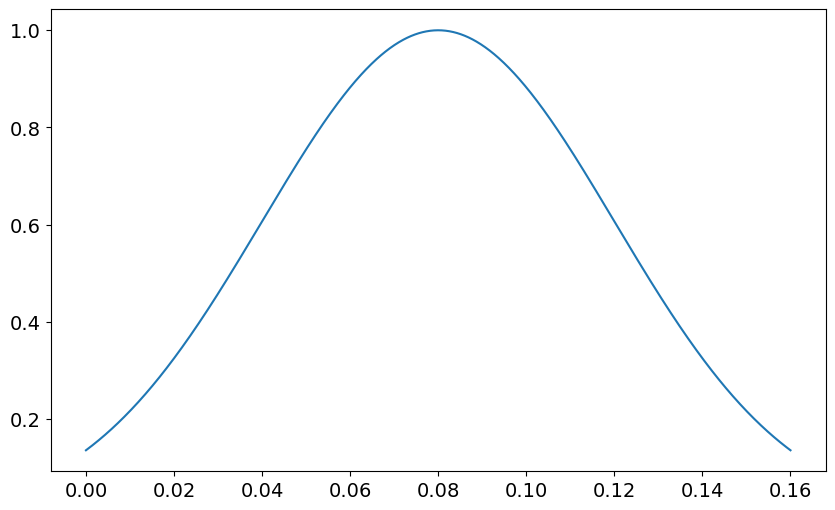

In [32]:
# make duration a multiple of 16
def pad_zeros(arr): 
    '''
    if pulse not multiple of 16, pads it with 0s
    '''
    arr = list(arr)
    while len(arr) % 16 != 0 :
        arr.append(0)
    return arr

arg = {}
arg['start'] = 0
arg['sigma'] = 0.04   # in us
arg['wx1'] = 3568.7859531189238     # in MHz
arg['phase'] = 0
arg['gain'] = 1
tlist = np.linspace(0, 4*arg['sigma'], int(4 * sigma/ (soc.cycles2us(1)) * 16)+1)
opt_pulse = (Gaussian(tlist,arg))
plt.plot(tlist, opt_pulse)

pulse_filename = './/optimal control//20240219_test_optimal1.npy'
i_arr = pad_zeros(opt_pulse)
q_arr = np.zeros_like(pad_zeros(opt_pulse))
final_pulse = np.array([i_arr, q_arr])

np.save(pulse_filename, final_pulse)

In [35]:
max(final_pulse[0])

0.9999983501099652

In [16]:
pulse_filename = './/optimal control//20240219_test_optimal1.npy'
opt_test = meas.TestOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_opt",
    config_file=config_path,
)

opt_test.cfg.expt = dict(
    reps=1000,
    qubits=[0],
    opt_gain = int(17366/np.sqrt(2)),
    # opt_gain = 14000,
    opt_file_path= pulse_filename,
    )


print(opt_test.cfg)

import Pyro4.util
try:
    opt_test.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

opt_test.save_data()


{'prepulse_qubit': {'freq': [3568.7875139436787], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.7875139436787], 'f_ge_resolved': [3568.7875139436787], 'f_ef': [3426.154986272321], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17366], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [73], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8592], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6639], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3441], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

In [17]:
temp_data1 = opt_test.data
tre = opt_test.cfg.device.readout.threshold[0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
np.shape(temp_data1['i0'])
print('Population in |e> state : ' + str(allocated_readout[0]/1000))

Population in |e> state : 0.97


(-0.5807317073170732, 17.811626016260163, 5.114796747967479, 21.69170731707317)

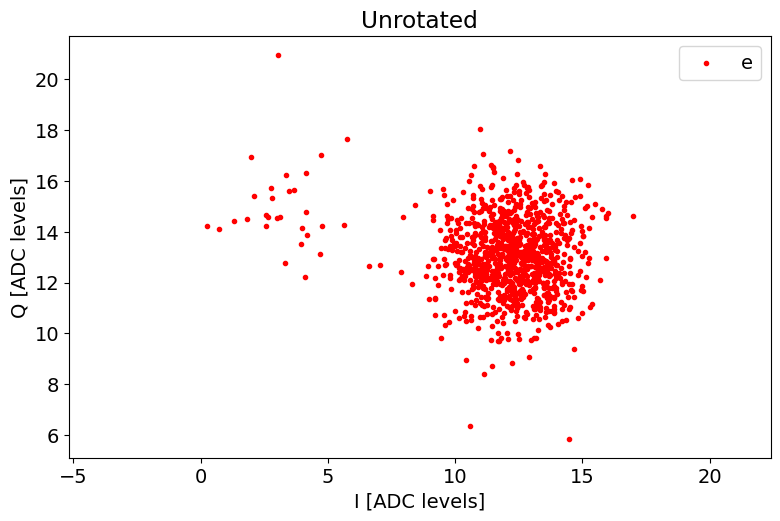

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
fig.tight_layout()

axs.scatter(temp_data1['i0'], temp_data1['q0'], label='e', color='r', marker='.')
axs.set_xlabel('I [ADC levels]')
axs.set_ylabel('Q [ADC levels]')
axs.legend(loc='upper right')
axs.set_title('Unrotated')
axs.axis('equal')

In [21]:
soc.us2cycles(1)

430

## calibrate qubit <-> cavity drive delay time

In [19]:
cavity2qubit = meas.Cavity2QubitSweepExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"Cavity_qubit_sweep",
    config_file=config_path,
)

# 860 cycles is 2 us

cavity2qubit.cfg.expt = dict(
    start=10, # cycles
    step=6, # cycles
    qubits=[0],
    expts=251,
    reps=100,
    rounds=10,
    qubit_resolved_pi = [3568.6366491011734, 257, 2, 0.1],     # [freq, gain, flat (us), sigma (us)]  qubit resolved pi pulse for readout
    prepulse = True,
    postpulse = False,
    pre_sweep_pulse = [[4984.217293492691],[1000],[1.0],[0],[6]],   # [[frequency], [gain], [length (us)], [phases], [drive channel]], drive channel=1 (flux low),3 (flux high),4 (storage),5 (flux storage),6 (manipulate),           
    post_sweep_pulse = [[337.3],[5000],[0.4283],[0],[1]]   # [[frequency], [gain], [length (us)], [phases], [drive channel]], drive channel=1 (flux low),3 (flux high),4 (storage),5 (flux storage),6 (manipulate)
)

print(cavity2qubit.cfg)
import Pyro4.util
try:
    cavity2qubit.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit_general.h5')

{'prepulse_qubit': {'freq': [3568.8966491011734], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.8966491011734], 'f_ge_resolved': [3568.8966491011734], 'f_ef': [3426.163873165147], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17457], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [72], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8855], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6537], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3270], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

  0%|          | 0/251 [00:00<?, ?it/s]

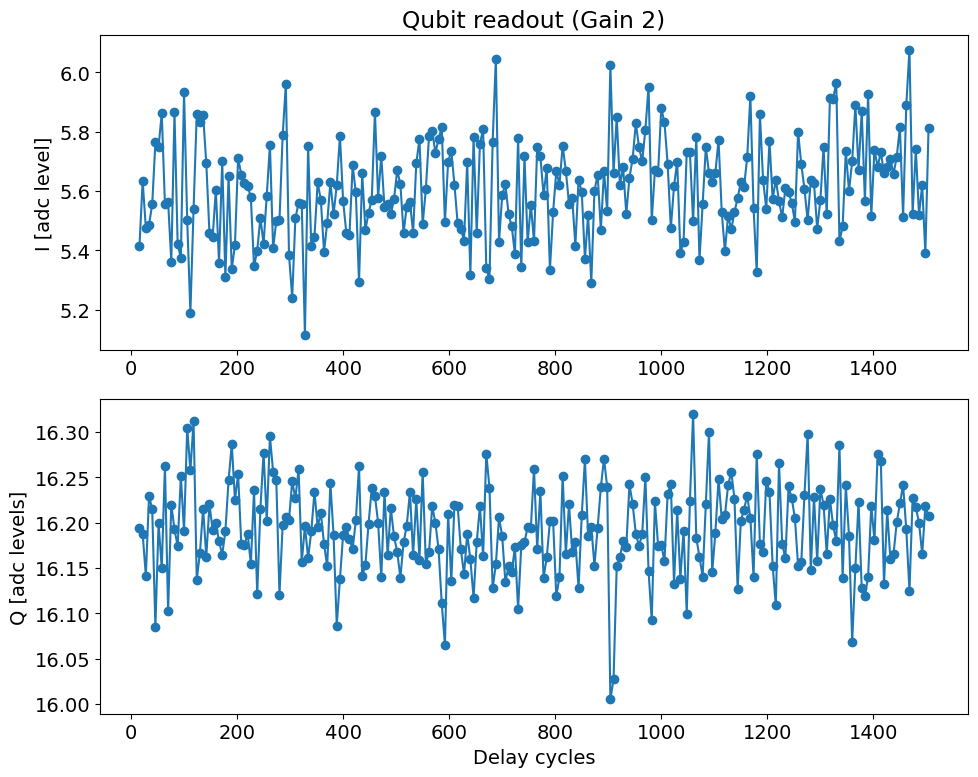

Saving H:\Shared drives\multimode\Multimode\experiment\240304\data\00003_Cavity_qubit_sweep.h5


'H:\\Shared drives\\multimode\\Multimode\\experiment\\240304\\data\\00003_Cavity_qubit_sweep.h5'

In [20]:
cavity2qubit.analyze(fit=False)
cavity2qubit.display(fit=False)
cavity2qubit.save_data()

#### therefore, qubit pulses should be 260 cycles ahead of cavity pulses

## preparing fock state |1>

### Drive Hamiltonian in Qctrl: A(a+a.dag()), need to convert A to DAC gain

In [12]:
qubit_pulse_filename = './/optimal control//qubit_pulse.npy'
cavity_pulse_filename = './/optimal control//cavity_pulse.npy'
Gaussian_pi_gain = 17410
time_length = 3.5  # us
qq = np.load(qubit_pulse_filename)
cc = np.load(cavity_pulse_filename)
# convert it to IQ
qq_Q = np.real(qq)
qq_I = np.imag(qq)
segment_count = len(qq_Q)
ratio_q = np.pi/2/np.sqrt(2*np.pi)/0.04/erf(np.sqrt(2))
gain2alpha = 0.001148213
ratio_c = np.pi*2*gain2alpha

cc_Q = np.real(cc)
cc_I = np.imag(cc)

tosave_qubit_Q = []
tosave_qubit_I = []
tosave_cavity_Q = []
tosave_cavity_I = []

segment2cycles = int((time_length/segment_count)/ (soc.cycles2us(1)) * 16+1)
for i in range(segment_count):

    tosave_qubit_Q.append(np.ones(segment2cycles)*qq_Q[i]/1e6/ratio_q)   # scale to the gaussian pi pulse case
    tosave_qubit_I.append(np.ones(segment2cycles)*qq_I[i]/1e6/ratio_q)

    tosave_cavity_Q.append(np.ones(segment2cycles)*(cc_Q[i]/1e6))
    tosave_cavity_I.append(np.ones(segment2cycles)*(cc_I[i]/1e6))  # scale to reference gain = 1


# scale pulses to between 0-1, record the scaling factor
qubit_gain = np.max([np.max(tosave_qubit_Q),np.max(tosave_qubit_I)])
cavity_gain = np.max([np.max(tosave_cavity_Q),np.max(tosave_cavity_Q)])

delay_cycles = 260       # in cycles, qubit pulse needs to shift 260 cycles ahead
# convert it to actual pulses
qubit_file = []
qubit_file.append(np.array(tosave_qubit_Q/qubit_gain).flatten())
qubit_file.append(np.array(tosave_qubit_I/qubit_gain).flatten())
cavity_file = []
cavity_file.append(np.array(tosave_cavity_Q/cavity_gain).flatten())
cavity_file.append(np.array(tosave_cavity_I/cavity_gain).flatten())
pulse_filename = './/optimal control//20240222_qubit_optimal.npy'
np.save(pulse_filename, qubit_file)
pulse_filename = './/optimal control//20240222_cavity_optimal.npy'
np.save(pulse_filename, cavity_file)



In [13]:
qubit_pulse_filename = './/optimal control//20240222_qubit_optimal.npy'
cavity_pulse_filename = './/optimal control//20240222_cavity_optimal.npy'
opt_test = meas.QubitCavityOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"test_opt",
    config_file=config_path,
)

opt_test.cfg.expt = dict(
    reps=1000,
    qubits=[0],
    opt_freq = [3568.7888873838688, 4984.376405764741],
    opt_gain = [int(qubit_gain*Gaussian_pi_gain/np.sqrt(2)), int(cavity_gain/gain2alpha/np.sqrt(2))],
    # opt_gain = [1,1],
    opt_delay_start = [0, 260],   # in cycles
    opt_file_path= [qubit_pulse_filename, cavity_pulse_filename]
    )


print(opt_test.cfg)

import Pyro4.util
try:
    opt_test.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

opt_test.save_data()


{'prepulse_qubit': {'freq': [3568.7888873838688], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.7888873838688], 'f_ge_resolved': [3568.7888873838688], 'f_ef': [3426.154986272321], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17410], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [72], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8874], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6639], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3441], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

In [14]:
temp_data1 = opt_test.data
tre = opt_test.cfg.device.readout.threshold[0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
np.shape(temp_data1['i0'])
print('Population in |e> state : ' + str(allocated_readout[0]/1000))

Population in |e> state : 0.923


(1.7929268292682927, 20.192439024390243, -4.700325203252032, 12.96048780487805)

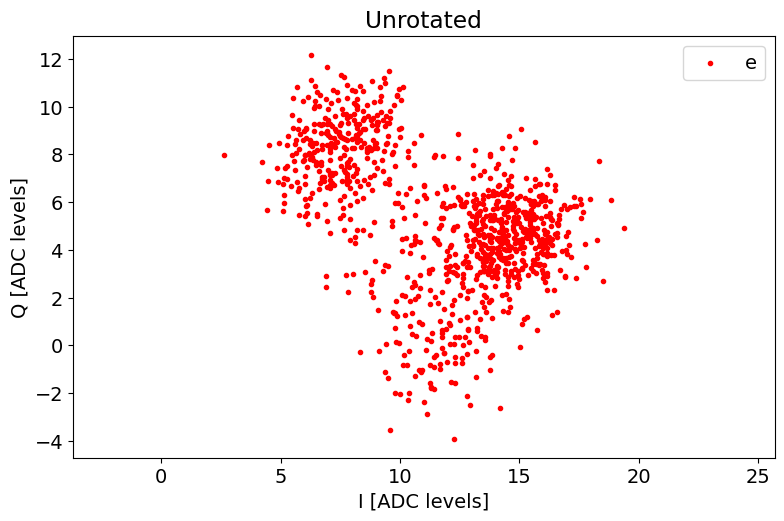

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
fig.tight_layout()

axs.scatter(temp_data1['i0'], temp_data1['q0'], label='e', color='r', marker='.')
axs.set_xlabel('I [ADC levels]')
axs.set_ylabel('Q [ADC levels]')
axs.legend(loc='upper right')
axs.set_title('Unrotated')
axs.axis('equal')

### perform tomography after opt pulse

In [16]:
wigner_exp = meas.WignerTomography1ModeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"Wigner_tomography",
    config_file=config_path,
)

# alpha_list = np.arange(0,6.1,0.3)
# gain_list = [int(x/0.000239708) for x in alpha_list]

wigner_exp.cfg.expt = dict(
    gain2alpha = 0.001148213,
    cavity_name = 0,   # displaced cavity name
    displace_length = 1,    # displace length in us, pulse shape is gaussian
    I_list = np.linspace(-3.0,3.0,21),    #  displace gain
    Q_list = np.linspace(-3.0,3.0,21),   # in deg
    prepulse = False,
    pre_sweep_pulse = [[4984.533795427038],[2000],[2.0],[0],[6],['flat_top'], [0.01]],
    # pre_sweep_pulse = [[4984.533795427038, 1, 337.4],[2000, 0,  8000],[2.0,3.0, 0.23581121290573867],[0,0,0],[6,6,1],['flat_top','const','flat_top'], [0.01,0, 0.01]],   # pre pulses shapes and sigma length (if used) flat_top, const, gaussian
                                            # [[frequency], [gain], [length (us)], [phases], [drive channel]], drive channel=1 (flux low),3 (flux high),4 (storage),5 (flux storage),6 (manipulate),           
    reps=2000,
    qubits=[0],
    optpulse = True,
    opt_freq = [3568.7888873838688, 4984.376405764741],
    opt_gain = [int(qubit_gain*Gaussian_pi_gain/np.sqrt(2)), int(cavity_gain/gain2alpha/np.sqrt(2))],
    # opt_gain = [1,1],
    opt_delay_start = [0, 260],   # in cycles
    opt_file_path= [qubit_pulse_filename, cavity_pulse_filename]
    )


print(wigner_exp.cfg)

import Pyro4.util
try:
    wigner_exp.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'prepulse_qubit': {'freq': [3568.7888873838688], 'length': [0.06], 'gain': [30], 'phase': [0], 'repeat_time': 10}, 'device': {'qubit': {'T1': [127.0], 'f_ge': [3568.7888873838688], 'f_ge_resolved': [3568.7888873838688], 'f_ef': [3426.154986272321], 'ramp_sigma': [0.01], 'ramp_sigma_num': [2], 'pulses': {'pi_ge': {'gain': [17410], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ge_middle': {'gain': [3370], 'sigma': [0.2], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [72], 'sigma': [0.1], 'length': 7, 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [8874], 'sigma': [0.04], 'type': 'gauss'}, 'pi_ef_new': {'gain': [6580], 'sigma': [0.005], 'length': 0.08405005321695154, 'type': 'flat_top'}, 'hpi_ef_new': {'gain': [3529], 'sigma': [0.005], 'length': 0.07713167413411094, 'type': 'flat_top'}, 'pi_ef': {'gain': [6639], 'sigma': [0.08], 'type': 'gauss'}, 'hpi_ef': {'gain': [3441], 'sigma': [0.08], 'type': 'gauss'}, 'f0g1': {'gain': [10000], 'length': [0.8252313910527852], 'sigma': [0.005]}}, 'f

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
wigner_exp.save_data()

Saving E:\Shared drives\multimode\Multimode\experiment\240205\data\00018_Wigner_tomography.h5


Text(0, 0.5, 'Wigner Function')

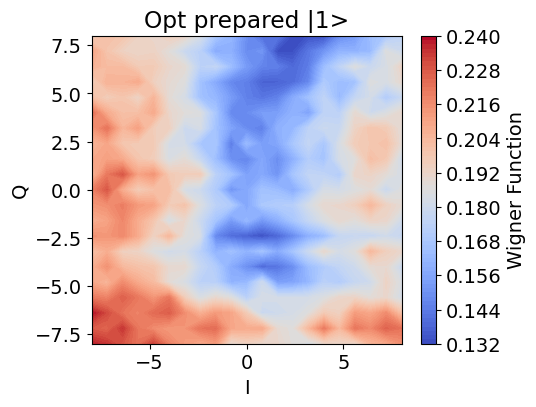

In [18]:
temp_data1, attrs1 = prev_data(expt_path, '00018_Wigner_tomography.h5') 
I_list = np.linspace(-8.0,8.0,21)
Q_list = np.linspace(-8.0,8.0,21)

tre = attrs1['config']['device']['readout']['threshold'][0]
allocated_readout = []
for ii in range(len(temp_data1['i0'])):
    counts = 0
    for jj in range(len(temp_data1['i0'][ii][0])):
        if temp_data1['i0'][ii][0][jj] > tre:
            counts += 1
    allocated_readout.append(counts)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cont0 = axes.contourf(I_list, Q_list, np.reshape(np.array(allocated_readout)/len(temp_data1['i0'][ii][0])/np.pi,[len(I_list),len(Q_list)]), 100, cmap=plt.cm.coolwarm)
cbar = fig.colorbar(cont0)
axes.set_title('Opt prepared |1>')
axes.set_xlabel('I')
axes.set_ylabel('Q')
cbar.ax.set_ylabel('Wigner Function')